In [2]:
# This module is for loading the required OBS data for LRM training, from MAC-LWP, CERES_EBAF-TOA_Ed4.1, and MERRA-2 Reanalysis.

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import xarray
import pandas
import glob

from scipy.stats import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

from area_mean import *
from binned_cyFunctions5 import *
from read_hs_file import read_var_mod
from read_var_obs import *

# calc_LRMobs_metric.py

In [1]:
### This module is to get the obs data we need from read func: 'get_OBSLRMdata', and calculate for CCFs and the required Cloud properties; 
## Crop regions, Transform the data to be annually mean, binned array form;
## Create the linear regression 2 & 4 regimes models from current climate sensitivity of cloud properties to the CCFs and save the data.

import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr


import pandas as pd
import glob
from copy import deepcopy
from scipy.stats import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
# self_defined modules
from area_mean import *
from binned_cyFunctions5 import *
from read_hs_file import read_var_mod
from read_var_obs import *
from get_LWPCMIP5data import *
from get_LWPCMIP6data import *
from get_OBSLRMdata import *
from fitLRM_cy1 import *
from fitLRM_cy2 import *
from fitLRM_cy4 import *
from useful_func_cy import *
from calc_Radiation_LRM_1 import *
from calc_Radiation_LRM_2 import *

In [ ]:
# get the variable:
test_flag = 'test1'
inputVar_obs = get_OBSLRM(test = test_flag)
# ------------------------ 
# radiation code

# ------------------------

# Data processing
# GMT: Global mean surface air Temperature (2-meter), Unit in K
gmt = inputVar_obs['tas'] * 1.
# SST: Sea Surface Temperature or skin- Temperature, Unit in K
SST = inputVar_obs['sfc_T'] * 1.
# Precip: Precipitation, Unit in mm day^-1 (convert from kg m^-2 s^-1)
Precip = inputVar_obs['P'] * (24. * 60 * 60)
# Eva: Evaporation, Unit in mm day^-1 (here use the latent heat flux from the sfc, unit convert from W m^-2 --> kg m^-2 s^-1 --> mm day^-1)
lh_vaporization = (2.501 - (2.361 * 10**-3) * (SST - 273.15)) * 1e6  # the latent heat of vaporization at the surface Temperature
Eva = inputVar_obs['E'] / lh_vaporization * (24. * 60 * 60)

# MC: Moisture Convergence, represent the water vapor abundance, Unit in mm day^-1
MC = Precip - Eva
print(MC)

# LTS: Lower Tropospheric Stability, Unit in K (the same as Potential Temperature):
k = 0.286

theta_700 = inputVar_obs['T_700'] * (100000. / 70000.)**k
theta_skin = inputVar_obs['sfc_T'] * (100000. / inputVar_obs['sfc_P'])**k
LTS_m = theta_700 - theta_skin  # LTS with np.nan

#.. mask the place with np.nan value
LTS_e = np.ma.masked_where(theta_700==np.nan, LTS_m)
# print(LTS_e)

Subsidence = inputVar_obs['sub']

# define Dictionary to store: CCFs(4), gmt, other variables :
dict0_var = {'gmt': gmt, 'SST': SST, 'p_e': MC, 'LTS': LTS_e, 'SUB': Subsidence}  #  ,'LWP': LWP, 'rsdt': Rsdt_pi, 'rsut': Rsut_pi, 'rsutcs': Rsutcs_pi, 'albedo' : Albedo_pi, 'albedo_cs': Albedo_cs_pi, 'alpha_cre': Alpha_cre_pi, 

# Crop the regions
# crop the variables to the Southern Ocean latitude range: (40 ~ 85^o S)

variable_nas = ['SST', 'p_e', 'LTS', 'SUB']

dict1_SO, lat_merra2_so, lon_merra2_so = region_cropping(dict0_var, variable_nas, inputVar_obs['lat_merra2'], inputVar_obs['lon_merra2'], lat_range = [-85., -40.], lon_range = [-180., 180.])

# Time-scale average
# monthly mean (not changed)
dict2_SO_mon = deepcopy(dict1_SO)

# annually mean variable
dict2_SO_yr = get_annually_dict(dict1_SO, ['gmt', 'SST', 'p_e', 'LTS', 'SUB'], inputVar_obs['times_merra2'], label = 'mon')

# binned (spatial) avergae
# Southern Ocean 5 * 5 degree bin box

#..set are-mean range and define function
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
x_range = arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) +2.5  #..southern-ocaen latitude edge: 9
# binned Monthly variables:
dict3_SO_mon_bin = {}

for c in range(len(variable_nas)):

    dict3_SO_mon_bin[variable_nas[c]] = binned_cySouthOcean5(dict2_SO_mon[variable_nas[c]], lat_merra2_so, lon_merra2_so)

dict3_SO_mon_bin['gmt'] = binned_cyGlobal5(dict2_SO_mon['gmt'], inputVar_obs['lat_merra2'], lon_merra2_so)
print("End monthly data binned.")

# binned Annually data:
dict3_SO_yr_bin = get_annually_dict(dict3_SO_mon_bin, ['gmt', 'SST', 'p_e', 'LTS', 'SUB'], inputVar_obs['times_merra2'])
print("End annually data binned.")

/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/read_var_obs.py:66: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  tt1 = nc.num2date(tt[i], file.variables['time'].units,calendar = u'standard')  # cf.Datetime object: including yr, mon, day, hour, minute, second info


(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[[[0.3376463  0.3376463  0.3376463  ... 0.3376463  0.3376463  0.3376463 ]
  [0.34254223 0.34311178 0.343692   ... 0.34082732 0.34139964 0.3419718 ]
  [0.31732705 0.31867892 0.3200711  ... 0.3133953  0.31468073 0.3159917 ]
  ...
  [0.32840103 0.3282132  0.32801944 ... 0.32895696 0.3287822  0.32860112]
  [0.31479692 0.31471968 0.3146458  ... 0.315017   0.31493765 0.31486344]
  [0.29702592 0.29702592 0.29702592 ... 0.29702592 0.29702592 0.29702592]]

 [[0.32060426 0.32060426 0.32060426 ... 0.32060426 0.32060426 0.32060426]
  [0.28848466 0.28902537 0.28957465 ... 0.28687114 0.28740743 0.28794304]
  [0.24156712 0.24262238 0.24370147 ... 0.23853074 0.2395203  0.24053104]
  ...
  [0.55581355 0.5575762  0.5593538  ... 0.5506113  0.55231833 0.5540736 ]
  [0.559898   0.56035906 0.56083226 ... 0.55844355 0.55893636 0.55942273]
  [0.53008854 0.53008854 0.53008854 ... 0.53008854 0.53008854 0.53008854]]

 [[0.26042917 0.26042917 0.26042917 ... 0.26042917 0.2604291

/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:178: RuntimeWarning: Mean of empty slice
  annually_array[i,:,:] = nanmean(dict_annually_mean[variable_nas[v]][i*12+(13-int(times[0,1])):(i+1)*12+(13-int(times[0,1])),:,:], axis = 0)


End monthly data binned.
End annually data binned.


In [ ]:
XX, YY = np.meshgrid(lon, lat, indexing='xy')
#..Southern Ocean region from 85S 40S
x_range = np.arange(-180., 183, 5.)   #..number:73
y_range = np.arange(-85., -35, 5.)   #.. (9)

xbins, ybins = len(x_range) - 1, len(y_range) - 1

S_binned_array = np.zeros((S.shape[0], ybins, xbins))

for i in np.arange(S.shape[0]):
    S_time_step = S[i,:,:]

    #..find and subtract the missing points
    ind =  np.isnan(S[i,:,:]) == False
    S_binned_time, xedge, yedge, binnumber = stats.binned_statistic_2d(XX[ind].ravel(),YY[ind].ravel(), values = S_time_step[ind].ravel(), statistic = 'mean', bins=[xbins, ybins], expand_binnumbers =True)

    S_binned_array[i,:,:] = S_binned_time.T


NameError: name 'S' is not defined

In [ ]:
# get the variable:

inputVar_obs = get_OBSLRM(valid_range1=valid_range3, valid_range2=valid_range4)
# ------------------------ 
# radiation code

# ------------------------

# Data processing
# - Liquid water path, Unit in kg m^-2
LWP = inputVar_obs['lwp'] / 1000.
# 1-Sigma Liquid water path statistic error, Unit in Kg m^-2
LWP_error = inputVar_obs['lwp_error'] / 1000.
# the MaskedArray of 'MAC-LWP' dataset
Maskarray_mac = inputVar_obs['maskarray_mac']
# ---

# GMT: Global mean surface air Temperature (2-meter), Unit in K
gmt = inputVar_obs['tas'] * 1.
# SST: Sea Surface Temperature or skin- Temperature, Unit in K
SST = inputVar_obs['sfc_T'] * 1.
# Precip: Precipitation, Unit in mm day^-1 (convert from kg m^-2 s^-1)
Precip = inputVar_obs['P'] * (24. * 60 * 60)
# Eva: Evaporation, Unit in mm day^-1 (here use the latent heat flux from the sfc, unit convert from W m^-2 --> kg m^-2 s^-1 --> mm day^-1)
lh_vaporization = (2.501 - (2.361 * 10**-3) * (SST - 273.15)) * 1e6  # the latent heat of vaporization at the surface Temperature
Eva = inputVar_obs['E'] / lh_vaporization * (24. * 60 * 60)

# MC: Moisture Convergence, represent the water vapor abundance, Unit in mm day^-1
MC = Precip - Eva
print(MC)

# LTS: Lower Tropospheric Stability, Unit in K (the same as Potential Temperature):
k = 0.286

theta_700 = inputVar_obs['T_700'] * (100000. / 70000.)**k
theta_skin = inputVar_obs['sfc_T'] * (100000. / inputVar_obs['sfc_P'])**k
LTS_m = theta_700 - theta_skin  # LTS with np.nan

#.. mask the place with np.nan value
LTS_e = np.ma.masked_where(theta_700==np.nan, LTS_m)
# print(LTS_e)

Subsidence = inputVar_obs['sub']

# SW radiative flux:
Rsdt = inputVar_obs['rsdt']
Rsut = inputVar_obs['rsut']
Rsutcs = inputVar_obs['rsutcs']

albedo = Rsut / Rsdt
albedo_cs = Rsutcs / Rsdt
Alpha_cre = albedo - albedo_cs
# abnormal values:
albedo_cs[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
Alpha_cre[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan

# define Dictionary to store: CCFs(4), gmt, other variables :
dict0_var = {'gmt': gmt, 'SST': SST, 'p_e': MC, 'LTS': LTS_m, 'SUB': Subsidence, 'LWP': LWP, 'rsdt': Rsdt, 'rsut': Rsut, 'rsutcs': Rsutcs, 'albedo' : albedo, 'albedo_cs': albedo_cs, 'alpha_cre': Alpha_cre, 'LWP_statistic_error': LWP_error, 'Maskarray_mac': Maskarray_mac}

# Crop the regions
# crop the variables to the Southern Ocean latitude range: (40 ~ 85^o S)

variable_nas = ['gmt', 'SST', 'p_e', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre', 'Maskarray_mac']   # all variables names.
variable_MERRA2 = ['gmt', 'SST', 'p_e', 'LTS', 'SUB']
variable_CCF = ['SST', 'p_e', 'LTS', 'SUB']
variable_MAC = ['LWP', 'LWP_statistic_error', 'Maskarray_mac']
variable_CERES = ['rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']

dict1_SO, lat_merra2_so, lon_merra2_so = region_cropping(dict0_var, ['SST', 'p_e', 'LTS', 'SUB'], inputVar_obs['lat_merra2'], inputVar_obs['lon_merra2'], lat_range = [-85., -40.], lon_range = [-180., 180.])

dict1_SO, lat_mac_so, lon_mac_so = region_cropping(dict1_SO, ['LWP', 'LWP_statistic_error', 'Maskarray_mac'], inputVar_obs['lat_mac'], inputVar_obs['lon_mac'], lat_range =[-85., -40.], lon_range = [-180., 180.])


# Time-scale average
# monthly mean (not changed)
dict2_SO_mon = deepcopy(dict1_SO)

# annually mean variable
dict2_SO_yr = get_annually_dict(dict1_SO, ['gmt', 'SST', 'p_e', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre'], inputVar_obs['times_merra2'], label = 'mon')


# Propagate the np.nan values in 3 different datasets
# monthly data
test_array_mon = np.ones((dict2_SO_mon['LWP'].shape))
for i in ['SST', 'p_e', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
    if dict2_SO_mon[i].shape == dict2_SO_mon['LWP'].shape:
        test_array_mon = test_array_mon * (1. * dict2_SO_mon[i])

shape_ratio_mon = np.asarray(np.nonzero(np.isnan(test_array_mon) == True)).shape[1] / len(test_array_mon.flatten())

Maskarray_all_mon = np.isnan(test_array_mon)  # store the mask positions for monthly MERRA-2, MAC-LWP, CERES data in the SO;

x_array_mon = np.zeros((dict2_SO_mon['SST'].shape))  # used for count the missing points in monthly binned boxes
x_array_mon[np.isnan(test_array_mon)] = 1.0
# print(shape_ratio_mon, x_array_mon)

# Propagating the .nan into monthly mean data:
for j in ['SST', 'p_e', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
    if dict2_SO_mon[j].shape == dict2_SO_mon['LWP'].shape:
        dict2_SO_mon[j][Maskarray_all_mon] = np.nan

# annually data
test_array_yr = np.ones((dict2_SO_yr['LWP'].shape))
for i in ['SST', 'p_e', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
        if dict2_SO_yr[i].shape == dict2_SO_yr['LWP'].shape:
            test_array_yr = test_array_yr * (1. * dict2_SO_yr[i])

shape_ratio_yr = np.asarray(np.nonzero(np.isnan(test_array_yr) == True)).shape[1] / len(test_array_yr.flatten())
# print(shape_ratio_yr)
Maskarray_all_yr = np.isnan(test_array_yr)  # store the mask positions for annually mean MERRA-2, MAC-LWP, CERES data in the SO;

x_array_yr = np.zeros((dict2_SO_yr['SST'].shape))  # used for count the missing points in annually mean binned boxes
x_array_yr[np.isnan(test_array_yr)] = 1.0

# Propagating the .nan into annually mean data:
for j in ['SST', 'p_e', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
    if dict2_SO_yr[j].shape == dict2_SO_yr['LWP'].shape:
        dict2_SO_yr[j][Maskarray_all_yr] = np.nan

# binned (spatial) avergae.
# Southern Ocean 5 * 5 degree bin box

#..set are-mean range and define function
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
x_range = arange(-180., 180.5, 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) + 2.5  #..southern-ocaen latitude edge: 9


# binned Monthly variables:
dict3_SO_mon_bin = {}

for e in ['SST', 'p_e', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:

    dict3_SO_mon_bin[e] = binned_cySouthOcean5(dict2_SO_mon[e], inputVar_obs['lat_ceres'], inputVar_obs['lon_ceres'])
    # since the latitide/ longitude grid for MERRA-2 (data_type = '2') and MAC-LWP/ CERES-EBAF-TOA_Ed4.1 are the same, it does not matter for the choice of lat/lon.

dict3_SO_mon_bin['gmt'] = binned_cyGlobal5(dict2_SO_mon['gmt'], inputVar_obs['lat_merra2'], inputVar_obs['lon_merra2'])
print("End monthly data binned.")

# binned Annually data (it's different than do the binned operation on the 'dict2_SO_yr'):
dict3_SO_yr_bin = get_annually_dict(dict3_SO_mon_bin, ['gmt', 'SST', 'p_e', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre'], inputVar_obs['times_merra2'])

print("End annually data binned.")

# count the ratio of values that are missing in each bin boxes:
ratio_array = binned_cySO_count(x_array_mon, inputVar_obs['lat_ceres'], inputVar_obs['lon_ceres'])

ind_binned_omit = np.where(ratio_array >0.499, True, False)  # ignoring bin boxes which has the ratio of np.nan points over 0.5.

shape_ratio_bin = np.asarray(np.nonzero(ind_binned_omit == True)).shape[1] / len(ind_binned_omit.flatten())
# print(shape_ratio_bin)   # ratio of bin boxes that should be omited

for k in ['SST', 'p_e', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
    if dict3_SO_mon_bin[k].shape == dict3_SO_mon_bin['LWP'].shape:
        dict3_SO_mon_bin[k][ind_binned_omit] = np.nan

# print(dict3_SO_mon_bin)

# useful_func_cy

In [ ]:
dict_crop = deepcopy(dict_raw)

ind_i = (lats >= min(lat_range)) & (lats <= max(lat_range))
lats_crop = lats[ind_i]
ind_j = (lons >= min(lon_range)) & (lons <= max(lon_range))
lons_crop = lons[ind_j]
print(lats_crop, lons_crop)

xxfor v in range(len(variable_nas)):

    if dict_crop[variable_nas[v]].ndim == 3:
        dict_crop[variable_nas[v]] = dict_crop[variable_nas[v]][:, ind_i, ind_j]  # variable in dictionary is in 3-D shape
    elif dict_crop[variable_nas[v]].ndim == 2:
        dict_crop[variable_nas[v]] = dict_crop[variable_nas[v]][ind_i, ind_j]  # variable in dictionary is in 2-D shape

    else:
        print(' A not valid dimension value for this variable: ', variable_nas[v])
        continue
print(' Ended cropping.')
return dict_crop, lats_crop, lons_crop

In [ ]:
exp = 'piControl'

# CMIP6: 31
AWICM11MR = {'modn': 'AWI-CM-1-1-MR', 'consort': 'AWI', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCCSMCM2MR = {'modn': 'BCC-CSM2-MR', 'consort': 'BCC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCESM1 = {'modn': 'BCC-ESM1', 'consort': 'BCC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CMCCCM2SR5 = {'modn': 'CMCC-CM2-SR5', 'consort': 'CMCC', 'cmip': 'cmip6', 
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2FV2 = {'modn': 'CESM2-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCM = {'modn': 'CESM2-WACCM', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCMFV2 = {'modn': 'CESM2-WACCM-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CNRMCM61 = {'modn': 'CNRM-CM6-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMCM61HR = {'modn': 'CNRM-CM6-1-HR', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMESM21 = {'modn': 'CNRM-ESM2-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CanESM5 = {'modn': 'CanESM5', 'consort': 'CCCma', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
E3SM10 = {'modn': 'E3SM-1-0', 'consort': 'E3SM-Project', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}

ECEarth3 = {'modn': 'EC-Earth3', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
ECEarth3Veg = {'modn': 'EC-Earth3-Veg', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}

FGOALSg3 = {'modn': 'FGOALS-g3', 'consort': 'CAS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21G = {'modn': 'GISS-E2-1-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21H = {'modn': 'GISS-E2-1-H', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE22G = {'modn': 'GISS-E2-2-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GFDLCM4 = {'modn': 'GFDL-CM4', 'consort': 'NOAA-GFDL', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
# HADGEM3 = {'modn': 'HadGEM3-GC31-LL', 'consort': 'MOHC', 'cmip': 'cmip6',
#             'exper': 'piControl', 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}   #..missing 'wap' in 'piControl' exp(Daniel says that HadGEM3-GC31 not using p-level, so doesn't have variables on p-level
INM_CM48 = {'modn': 'INM-CM4-8', 'consort': 'INM', 'cmip': 'cmip6', 
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
IPSLCM6ALR = {'modn': 'IPSL-CM6A-LR', 'consort': 'IPSL', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
MIROCES2L = {'modn': 'MIROC-ES2L', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}
MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MPIESM12LR = {'modn': 'MPI-ESM1-2-LR', 'consort': 'MPI-M', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MRIESM20 = {'modn': 'MRI-ESM2-0', 'consort': 'MRI', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NESM3 = {'modn': 'NESM3', 'consort': 'NUIST', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NorESM2MM = {'modn': 'NorESM2-MM', 'consort': 'NCC', 'cmip': 'cmip6',
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
SAM0 = {'modn': 'SAM0-UNICON', 'consort': 'SNU', 'cmip': 'cmip6', 
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
TaiESM1 = {'modn': 'TaiESM1', 'consort': 'AS-RCEC', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
# CMIP5: 11
ACCESS10 = {'modn': 'ACCESS1-0', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
ACCESS13 = {'modn': 'ACCESS1-3', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
BNUESM = {'modn': 'BNU-ESM', 'consort': 'BNU', 'cmip': 'cmip5',
          'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}

CCSM4 = {'modn': 'CCSM4', 'consort': 'NCAR', 'cmip': 'cmip5',
             'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CNRMCM5 = {'modn': 'CNRM-CM5', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CSIRO_Mk360 = {'modn': 'CSIRO-Mk3-6-0', 'consort': 'CSIRO-QCCCE', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CanESM2 = {'modn': 'CanESM2', 'consort': 'CCCma', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSg2 = {'modn': 'FGOALS-g2', 'consort': 'LASG-CESS', 'cmip': 'cmip5',   # missing 'prw' in piControl
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSs2 = {'modn': 'FGOALS-s2', 'consort': 'LASG-IAP', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLCM3 = {'modn': 'GFDL-CM3', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2H = {'modn': 'GISS-E2-H', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2R = {'modn': 'GISS-E2-R', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
IPSLCM5ALR = {'modn': 'IPSL-CM5A-LR', 'consort': 'IPSL', 'cmip': 'cmip5',
               'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MIROC5 = {'modn': 'MIROC5', 'consort': 'MIROC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMMR = {'modn': 'MPI-ESM-MR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
NorESM1M = {'modn': 'NorESM1-M', 'consort': 'NCC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}

deck2 = [BCCESM1, CanESM5, CESM2, CESM2FV2, CESM2WACCM, CNRMESM21, GISSE21G, GISSE21H, IPSLCM6ALR, MRIESM20, MIROC6, SAM0, E3SM10, FGOALSg3, GFDLCM4, CAMSCSM1, INM_CM48, MPIESM12LR, AWICM11MR, BCCCSMCM2MR, CMCCCM2SR5, CESM2WACCMFV2, CNRMCM61, CNRMCM61HR, ECEarth3, ECEarth3Veg, GISSE22G, MIROCES2L, NESM3, NorESM2MM, TaiESM1, BNUESM, CCSM4, CNRMCM5, CSIRO_Mk360, CanESM2, FGOALSg2, FGOALSs2, GFDLCM3, GISSE2H, GISSE2R, IPSLCM5ALR, MIROC5, MPIESMMR, NorESM1M]   # current # 31 (no.19) + 14 = 45


deck_nas2 = ['BCCESM1', 'CanESM5', 'CESM2', 'CESM2FV2', 'CESM2WACCM', 'CNRMESM2', 'GISSE21G', 'GISSE21H', 'IPSLCM6ALR', 'MRIESM20', 'MIROC6', 'SAM0', 'E3SM10', 'FGOALSg3', 'GFDLCM4', 'CAMSCSM1', 'INM_CM48', 'MPIESM12LR', 'AWICM11MR', 'BCCCSMCM2MR', 'CMCCCM2SR5', 'CESM2WACCMFV2', 'CNRMCM61', 'CNRMCM61HR', 'ECEarth3', 'ECEarth3Veg', 'GISSE22G', 'MIROCES2L', 'NESM3', 'NorESM2MM', 'TaiESM1', 'BNUESM', 'CCSM4', 'CNRMCM5', 'CSIRO_Mk360', 'CanESM2', 'FGOALSg2', 'FGOALSs2', 'GFDLCM3', 'GISSE2H', 'GISSE2R', 'IPSLCM5ALR', 'MIROC5', 'MPIESMMR', 'NorESM1M']  # current # 31 (np.19) + 14 = 45


# get cmip6 data:
name_j = 0
while name_j < len(deck_nas2):

    if modn == deck_nas2[name_j]:
        if (deck2[name_j]['cmip']=='cmip6') & (type_analysis == 'forecasting'):
            inputVar_pi, inputVar_abr = get_LWPCMIP6(**deck2[name_j])
        elif (deck2[name_j]['cmip']=='cmip5') & (type_analysis == 'forecasting'):
            inputVar_pi, inputVar_abr = get_LWPCMIP5(**deck2[name_j])
        else:       # port for historical analysis
            print('not existing data within cmip5 and cmip6 storage in scratch.')
        break
    print("Number of models: ", name_j)
    name_j += 1

#if name_j== len(deck_nas2) -1:
#   print("Don't have this model right now !")



# begin process data:
#..get the shapes of monthly data
shape_lat = len(inputVar_pi['lat'])
shape_lon = len(inputVar_pi['lon'])
shape_time_pi = len(inputVar_pi['times'])
shape_time_abr = len(inputVar_abr['times'])
#print(shape_lat, shape_lon, shape_time_pi, shape_time_abr)


#..choose lat 40 -85 °S as the Southern-Ocean Regions
lons        = inputVar_pi['lon']
lats        = inputVar_pi['lat'][:]

levels      = array(inputVar_abr['pres'])
times_abr   = inputVar_abr['times']
times_pi    = inputVar_pi['times']

lati0 = -40.
latsi0= min(range(len(lats)), key = lambda i: abs(lats[i] - lati0))
lati1 = -85.
latsi1= min(range(len(lats)), key = lambda i: abs(lats[i] - lati1))
print('lat index for 40.s; 85.s', latsi0, latsi1)


shape_latSO = (latsi0 - latsi1) + 1 
#print(shape_latSO)


#..abrupt4xCO2 Variables: LWP, tas(gmt), SST, p-e, LTS, subsidence
LWP_abr  = array(inputVar_abr['clwvi']) - array(inputVar_abr['clivi'])   #..units in kg m^-2

gmt_abr  = array(inputVar_abr['tas'])
SST_abr  = array(inputVar_abr['sfc_T'])

Precip_abr = array(inputVar_abr['P']) * (24.*60.*60.)   #.. Precipitation. Convert the units from kg m^-2 s^-1 -> mm*day^-1

lh_vaporization_abr = (2.501 - (2.361 * 10**-3) * (SST_abr - 273.15)) * 1e6  # the latent heat of vaporization at the surface Temperature
# Eva_abr2 = array(inputVar_abr['E']) * (24. * 60 * 60)
Eva_abr1 = array(inputVar_abr['E']) / lh_vaporization_abr * (24. * 60 * 60)  #.. Evaporation, mm day^-1

MC_abr = Precip_abr - Eva_abr1   #..Moisture Convergence calculated from abrupt4xCO2's P - E, Units in mm day^-1

Twp_abr  = array(inputVar_abr['clwvi'])
Iwp_abr  = array(inputVar_abr['clivi'])

if np.min(LWP_abr)<-1e-5:
    LWP_abr = Twp_abr
    print('clwvi mislabeled')
print('Abr simple global-mean-gmt(K): ', nanmean(gmt_abr))

#..pi-Control Variables: LWP, tas(gmt), SST, p-e, LTS, subsidence
LWP  = array(inputVar_pi['clwvi']) - array(inputVar_pi['clivi'])   #..units in kg m^-2

gmt  = array(inputVar_pi['tas'])
SST  = array(inputVar_pi['sfc_T'])

Precip = array(inputVar_pi['P'])* (24.*60.*60.)    #..Precipitation. Convert the units from kg m^-2 s^-1 -> mm*day^-1

lh_vaporization = (2.501 - (2.361 * 10**-3) * (SST - 273.15)) * 1e6  # the latent heat of vaporization at the surface Temperature
Eva1 = array(inputVar_pi['E']) / lh_vaporization * (24. * 60 * 60)
# Eva2 = array(inputVar_pi['E']) * (24.*60.*60.)   #..evaporation, mm day^-1

MC = Precip - Eva1   #..Moisture Convergence calculated from pi-Control's P - E, Units in mm day^-1

Twp  = array(inputVar_pi['clwvi'])
Iwp  = array(inputVar_pi['clivi'])

print('pi-C simple global mean-gmt(K): ', nanmean(gmt))
if np.min(LWP)<-1e-5:
    LWP = Twp
    print('clwvi mislabeled')

#..abrupt4xCO2
# Lower Tropospheric Stability:
k  = 0.286
theta_700_abr  = array(inputVar_abr['T_700']) * (100000./70000.)** k
theta_skin_abr = array(inputVar_abr['sfc_T']) * (100000./ array(inputVar_abr['sfc_P'])) **k
LTS_m_abr  = theta_700_abr - theta_skin_abr

#..Subtract the outliers in T_700 and LTS_m, 'nan' comes from missing T_700 data
LTS_e_abr  = ma.masked_where(theta_700_abr >= 500, LTS_m_abr)


# Meteorology Subsidence at 500 hPa, units in Pa s^-1:
Subsidence_abr =  array(inputVar_abr['sub'])


#..pi-Control 
# Lower Tropospheric Stability:
theta_700  = array(inputVar_pi['T_700']) * (100000./70000.)** k
theta_skin = array(inputVar_pi['sfc_T']) * (100000./ array(inputVar_pi['sfc_P'])) **k
LTS_m  = theta_700 - theta_skin

#..Subtract the outliers in T_700 and LTS_m 
LTS_e  = ma.masked_where(theta_700 >= 500, LTS_m)


#..Meteological Subsidence at 500 hPa, units in Pa s^-1:
Subsidence =  array(inputVar_pi['sub'])


# define Dictionary to store: CCFs(4), gmt, other variables:
dict0_PI_var = {'gmt': gmt, 'LWP': LWP, 'TWP': Twp, 'IWP': Iwp, 'SST': SST, 'p_e': MC, 'LTS': LTS_e, 'SUB': Subsidence
                 ,'lat':lats, 'lon':lons, 'times': times_pi, 'pres':levels}

dict0_abr_var = {'gmt': gmt_abr, 'LWP': LWP_abr, 'TWP': Twp_abr, 'IWP': Iwp_abr, 'SST': SST_abr, 'p_e': MC_abr, 'LTS': LTS_e_abr 
                 ,'SUB': Subsidence_abr, 'lat':lats, 'lon':lons, 'times': times_abr, 'pres':levels}



# get the Annual-mean, Southern-Ocean region arrays

datavar_nas = ['LWP', 'TWP', 'IWP', 'SST', 'p_e', 'LTS', 'SUB']   #..7 varisables except gmt (lon dimension diff)

dict1_PI_yr  = {}
dict1_abr_yr = {}

shape_yr_pi  = shape_time_pi//12
shape_yr_abr =  shape_time_abr//12


layover_yr_abr =  zeros((len(datavar_nas), shape_yr_abr, shape_latSO, shape_lon))
layover_yr_pi  =  zeros((len(datavar_nas), shape_yr_pi, shape_latSO, shape_lon))

layover_yr_abr_gmt =  zeros((shape_yr_abr, shape_lat, shape_lon))
layover_yr_pi_gmt =  zeros((shape_yr_pi, shape_lat, shape_lon))


for a in range(len(datavar_nas)):

    for i in range(shape_time_abr//12):
        layover_yr_abr[a, i,:,:] =  nanmean(dict0_abr_var[datavar_nas[a]][i*12:(i+1)*12, latsi1:latsi0+1,:], axis=0)

    dict1_abr_yr[datavar_nas[a]+'_yr'] =  layover_yr_abr[a,:]

    for j in range(shape_time_pi//12):
        layover_yr_pi[a, j,:,:]  = nanmean(dict0_PI_var[datavar_nas[a]][j*12:(j+1)*12,  latsi1:latsi0+1,:], axis=0)

    dict1_PI_yr[datavar_nas[a]+'_yr'] =  layover_yr_pi[a,:]

    print(datavar_nas[a], " finish calculating annually-mean array")   



for i in range(shape_time_abr//12):

    layover_yr_abr_gmt[i,:,:]  =  nanmean(dict0_abr_var['gmt'][i*12:(i+1)*12, :,:], axis=0)
dict1_abr_yr['gmt_yr']  =   layover_yr_abr_gmt


for j in range(shape_time_pi//12):
    layover_yr_pi_gmt[j,:,:]  =   nanmean(dict0_PI_var['gmt'][j*12:(j+1)*12, :,:], axis=0)
dict1_PI_yr['gmt_yr']  =   layover_yr_pi_gmt

print('gmt', " finsih calc annuallt mean gmt")



# Calculate 5*5 bin array for variables (LWP, CCFs) in Southern Ocean Region:

#..set are-mean range and define function
x_range  = arange(-180., 180., 5.) #..logitude sequences edge: number: 72
s_range  = arange(-90., 90, 5.)+ 2.5 #..global-region latitude edge: (36)
y_range  = arange(-85, -40., 5.) +2.5 #..southern-ocaen latitude edge: 9


# Annually variables in bin box: 
lat_array  = lats[latsi1:latsi0+1]
lon_array  = lons
lat_array1 =  lats
#..big storage dict
dict1_PI_var   = {}
dict1_abr_var  =  {}
dict1_yr_bin_PI  = {}
dict1_yr_bin_abr = {}


for b in range(len(datavar_nas)):

    dict1_yr_bin_abr[datavar_nas[b]+'_yr_bin']  =   binned_cySouthOcean5(dict1_abr_yr[datavar_nas[b]+'_yr'], lat_array, lon_array)
    dict1_yr_bin_PI[datavar_nas[b]+'_yr_bin']   =  binned_cySouthOcean5(dict1_PI_yr[datavar_nas[b]+'_yr'], lat_array, lon_array)
    print(datavar_nas[b], " finished calculating annually-mean bin array") 

dict1_yr_bin_abr['gmt_yr_bin']   =  binned_cyGlobal5(dict1_abr_yr['gmt_yr'], lat_array1, lon_array)
dict1_yr_bin_PI['gmt_yr_bin']   =  binned_cyGlobal5(dict1_PI_yr['gmt_yr'], lat_array1, lon_array)

print('gmt_yr_bin', " finish calc annually-mean binned gmt")

dict1_abr_var['dict1_yr_bin_abr']  =  dict1_yr_bin_abr
dict1_PI_var['dict1_yr_bin_PI']  = dict1_yr_bin_PI



# Monthly variables (same as above):
dict1_mon_bin_PI  = {}
dict1_mon_bin_abr = {}

for c in range(len(datavar_nas)):

    dict1_mon_bin_abr[datavar_nas[c]+'_mon_bin'] =  binned_cySouthOcean5(dict0_abr_var[datavar_nas[c]][:, latsi1:latsi0+1,:], lat_array, lon_array)
    dict1_mon_bin_PI[datavar_nas[c]+'_mon_bin'] = binned_cySouthOcean5(dict0_PI_var[datavar_nas[c]][:, latsi1:latsi0+1,:], lat_array, lon_array)
    print(datavar_nas[c], " finish calculating monthly-mean bin array")

dict1_mon_bin_abr['gmt_mon_bin'] = binned_cyGlobal5(dict0_abr_var['gmt'], lat_array1, lon_array)
dict1_mon_bin_PI['gmt_mon_bin'] = binned_cyGlobal5(dict0_PI_var['gmt'], lat_array1, lon_array)

print('gmt_mon_bin', " finish calc monthly-mean binned gmt")

dict1_abr_var['dict1_mon_bin_abr']  = dict1_mon_bin_abr
dict1_PI_var['dict1_mon_bin_PI']  = dict1_mon_bin_PI


# input the shapes of year and month of pi&abr exper into the raw data dictionaries:
dict1_abr_var['shape_yr'] = shape_yr_abr
dict1_PI_var['shape_yr'] = shape_yr_pi
dict1_abr_var['shape_mon'] = shape_time_abr
dict1_PI_var['shape_mon'] = shape_time_pi



# Output a dict for processing function in 'calc_LRM_metrics', stored the data dicts for PI and abr, with the model name_dict
# C_dict =  {'dict0_PI_var':dict1_PI_var, 'dict0_abr_var':dict1_abr_var, 'model_data':model_data}    #..revised in Dec.30th, at 2021,, note the name.


# Second step processing data

# load annually-mean bin data
dict1_yr_bin_PI  = dict1_PI_var['dict1_yr_bin_PI']
dict1_yr_bin_abr  = dict1_abr_var['dict1_yr_bin_abr']


# load monthly bin data
dict1_mon_bin_PI  = dict1_PI_var['dict1_mon_bin_PI']
dict1_mon_bin_abr  = dict1_abr_var['dict1_mon_bin_abr']

# data array in which shapes?
shape_yr_PI_3 = dict1_yr_bin_PI['LWP_yr_bin'].shape
shape_yr_abr_3 = dict1_yr_bin_abr['LWP_yr_bin'].shape

shape_yr_PI_gmt = dict1_yr_bin_PI['gmt_yr_bin'].shape
shape_yr_abr_gmt = dict1_yr_bin_abr['gmt_yr_bin'].shape

shape_mon_PI_3 = dict1_mon_bin_PI['LWP_mon_bin'].shape
shape_mon_abr_3 = dict1_mon_bin_abr['LWP_mon_bin'].shape

shape_mon_PI_gmt = dict1_mon_bin_PI['gmt_mon_bin'].shape
shape_mon_abr_gmt = dict1_mon_bin_abr['gmt_mon_bin'].shape

# flatten the data array for 'training' lrm  coefficience

dict2_predi_fla_PI = {}
dict2_predi_fla_abr = {}

#..Ravel binned array /Standardized data ARRAY :
for d in range(len(datavar_nas)):

    dict2_predi_fla_PI[datavar_nas[d]] = dict1_mon_bin_PI[datavar_nas[d]+'_mon_bin'].flatten()
    dict2_predi_fla_abr[datavar_nas[d]] = dict1_mon_bin_abr[datavar_nas[d]+'_mon_bin'].flatten()


#..Use area_mean method, 'np.repeat' and 'np.tile' to reproduce gmt area-mean Array as the same shape as other flattened variables
GMT_pi_mon  = area_mean(dict1_mon_bin_PI['gmt_mon_bin'], s_range,  x_range)   #..ALL in shape : shape_yr_abr(single dimension)
## dict2_predi_fla_PI['gmt']  = GMT_pi.repeat(730)   # something wrong when calc dX_dTg(dCCFS_dgmt)
GMT_abr_mon  = area_mean(dict1_mon_bin_abr['gmt_mon_bin'], s_range, x_range)   #..ALL in shape : shape_yr_abr(single dimension)
## dict2_predi_fla_abr['gmt'] = GMT_abr.repeat(730)

dict2_predi_fla_PI['gmt'] = dict1_mon_bin_PI['gmt_mon_bin'][:,1:11,:].flatten()
dict2_predi_fla_abr['gmt'] = dict1_mon_bin_abr['gmt_mon_bin'][:,1:11,:].flatten()

#  shape of flattened array:
shape_fla_PI = dict2_predi_fla_PI['LWP'].shape
shape_fla_abr = dict2_predi_fla_abr['LWP'].shape


# For pluging in different sets of cut-off(TR_sst & TR_sub) into LRM(s):

##  split cut-off: TR_sst and TR_sub for N1 and N2 slices in sort of self-defined (Mon)variable ranges

YY_ay_gcm  = dict1_mon_bin_PI['SST_mon_bin']
XX_ay_gcm  = dict1_mon_bin_PI['SUB_mon_bin']


y_gcm = linspace(nanpercentile(YY_ay_gcm, 5), nanpercentile(YY_ay_gcm, 99), 31)   #..supposed to be changed, 31
x_gcm = linspace(nanpercentile(XX_ay_gcm, 5), nanpercentile(XX_ay_gcm, 95), 22)   #.., 22

print("slice SUB bound:  ", x_gcm)
print("slice SST bound:  ", y_gcm)


# define cut-off

TR_sst =  full(len(y_gcm)-1, NaN)
TR_sub =  full(len(x_gcm) -1, NaN)

for c in arange(len(y_gcm)-1):
    TR_sst[c]  = (y_gcm[c] + y_gcm[c+1]) /2. 
print("TR_sst : ", TR_sst)
for f in arange(len(x_gcm) -1):
    TR_sub[f]  = (x_gcm[f] + x_gcm[f+1]) /2.
print("TR_sub : ",TR_sub )

#..storage N1*N2 shape output result:
s1  = zeros((len(TR_sst), len(TR_sub)))
s2  = zeros((len(TR_sst), len(TR_sub)))
s3  = zeros((len(TR_sst), len(TR_sub)))
s4  = zeros((len(TR_sst), len(TR_sub)))  
s5  = zeros((len(TR_sst), len(TR_sub)))   #.. for store training data R^2: coefficient of determination

cut_off1  = zeros((len(TR_sst), len(TR_sub)))   #..2d, len(y_gcm)-1 * len(x_gcm)-1
cut_off2  = zeros((len(TR_sst), len(TR_sub)))
coefa = []
coefb = []
coefc =  []
coefd = []

# plug the cut-off into LRM tring function:
for i in range(len(y_gcm)-1):
    for j in range(len(x_gcm)-1):
        s1[i,j], s2[i,j], s3[i,j], s4[i,j], s5[i,j], cut_off1[i,j], cut_off2[i,j], coef_a, coef_b, coef_c, coef_d = train_LRM_4(TR_sst[i], TR_sub[j], dict2_predi_fla_PI, dict2_predi_fla_abr, shape_fla_PI, shape_fla_abr)

        print('number:', i+j+ 2)

        coefa.append(coef_a)
        coefb.append(coef_b)
        coefc.append(coef_c)
        coefd.append(coef_d)

# find the least bias and its position:
min_pedict_absbias_id = unravel_index(nanargmin(s1, axis=None), s1.shape)
max_training_R2_id  = unravel_index(nanargmax(s5, axis=None),  s5.shape)

TR_minabias_SST =  y_gcm[min_pedict_absbias_id[0]]
TR_minabias_SUB =  x_gcm[min_pedict_absbias_id[1]]

TR_maxR2_SST  = y_gcm[max_training_R2_id[0]]
TR_maxR2_SUB  = x_gcm[max_training_R2_id[1]]



# Storage data into .npz file for each GCMs
WD = '/glade/scratch/chuyan/CMIP_output/'

savez(WD+ modn+'__'+ 'STAT_pi+abr_'+'22x_31y_Aug30th', bound_y = y_gcm,bound_x = x_gcm, stats_1 = s1, stats_2 = s2, stats_3 = s3, stats_4 = s4, stats_5 = s5, cut_off1=cut_off1, cut_off2=cut_off2, TR_minabias_SST=TR_minabias_SST, TR_minabias_SUB=TR_minabias_SUB, TR_maxR2_SST=TR_maxR2_SST, TR_maxR2_SUB=TR_maxR2_SUB,  coef_a = coefa, coef_b = coefb, coef_c = coefc, coefd = coefd)
return None

# P - E calculation/plotting

In [ ]:
exp = 'piControl'
# CMIP6 (30)
AWICM11MR = {'modn': 'AWI-CM-1-1-MR', 'consort': 'AWI', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCCSMCM2MR = {'modn': 'BCC-CSM2-MR', 'consort': 'BCC', 'cmip': 'cmip6',   # T700 (ta) and sfc_T (ts) have different time shape
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCESM1 = {'modn': 'BCC-ESM1', 'consort': 'BCC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CMCCCM2SR5 = {'modn': 'CMCC-CM2-SR5', 'consort': 'CMCC', 'cmip': 'cmip6', 
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2FV2 = {'modn': 'CESM2-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCM = {'modn': 'CESM2-WACCM', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCMFV2 = {'modn': 'CESM2-WACCM-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CNRMCM61 = {'modn': 'CNRM-CM6-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMCM61HR = {'modn': 'CNRM-CM6-1-HR', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMESM21 = {'modn': 'CNRM-ESM2-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CanESM5 = {'modn': 'CanESM5', 'consort': 'CCCma', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
E3SM10 = {'modn': 'E3SM-1-0', 'consort': 'E3SM-Project', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}

ECEarth3 = {'modn': 'EC-Earth3', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
ECEarth3Veg = {'modn': 'EC-Earth3-Veg', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}

FGOALSg3 = {'modn': 'FGOALS-g3', 'consort': 'CAS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21G = {'modn': 'GISS-E2-1-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21H = {'modn': 'GISS-E2-1-H', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE22G = {'modn': 'GISS-E2-2-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GFDLCM4 = {'modn': 'GFDL-CM4', 'consort': 'NOAA-GFDL', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
# HADGEM3 = {'modn': 'HadGEM3-GC31-LL', 'consort': 'MOHC', 'cmip': 'cmip6',
#             'exper': 'piControl', 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}   #..missing 'wap' in 'piControl' exp(Daniel says that HadGEM3-GC31 not using p-level, so doesn't have variables on p-level
INM_CM48 = {'modn': 'INM-CM4-8', 'consort': 'INM', 'cmip': 'cmip6', 
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}  #..data not available again 
IPSLCM6ALR = {'modn': 'IPSL-CM6A-LR', 'consort': 'IPSL', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
MIROCES2L = {'modn': 'MIROC-ES2L', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}
MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MPIESM12LR = {'modn': 'MPI-ESM1-2-LR', 'consort': 'MPI-M', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MRIESM20 = {'modn': 'MRI-ESM2-0', 'consort': 'MRI', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NESM3 = {'modn': 'NESM3', 'consort': 'NUIST', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NorESM2MM = {'modn': 'NorESM2-MM', 'consort': 'NCC', 'cmip': 'cmip6',
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
SAM0 = {'modn': 'SAM0-UNICON', 'consort': 'SNU', 'cmip': 'cmip6', 
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
TaiESM1 = {'modn': 'TaiESM1', 'consort': 'AS-RCEC', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

# CMIP5: (14)
ACCESS10 = {'modn': 'ACCESS1-0', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
ACCESS13 = {'modn': 'ACCESS1-3', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
BNUESM = {'modn': 'BNU-ESM', 'consort': 'BNU', 'cmip': 'cmip5',
          'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CCSM4 = {'modn': 'CCSM4', 'consort': 'NCAR', 'cmip': 'cmip5',
             'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CNRMCM5 = {'modn': 'CNRM-CM5', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CSIRO_Mk360 = {'modn': 'CSIRO-Mk3-6-0', 'consort': 'CSIRO-QCCCE', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CanESM2 = {'modn': 'CanESM2', 'consort': 'CCCma', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSg2 = {'modn': 'FGOALS-g2', 'consort': 'LASG-CESS', 'cmip': 'cmip5',   # missing 'prw' in piControl
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSs2 = {'modn': 'FGOALS-s2', 'consort': 'LASG-IAP', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLCM3 = {'modn': 'GFDL-CM3', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2H = {'modn': 'GISS-E2-H', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2R = {'modn': 'GISS-E2-R', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
IPSLCM5ALR = {'modn': 'IPSL-CM5A-LR', 'consort': 'IPSL', 'cmip': 'cmip5',
               'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MIROC5 = {'modn': 'MIROC5', 'consort': 'MIROC', 'cmip': 'cmip5',
             'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMMR = {'modn': 'MPI-ESM-MR', 'consort': 'MPI-M', 'cmip': 'cmip5',
             'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
NorESM1M = {'modn': 'NorESM1-M', 'consort': 'NCC', 'cmip': 'cmip5',
             'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}


deck = [BCCESM1, CanESM5, CESM2, CESM2FV2, CESM2WACCM, CNRMESM21, GISSE21G, GISSE21H, IPSLCM6ALR, MRIESM20, MIROC6, SAM0, E3SM10, FGOALSg3, GFDLCM4, CAMSCSM1, INM_CM48, MPIESM12LR, AWICM11MR, CMCCCM2SR5, CESM2WACCMFV2, CNRMCM61, CNRMCM61HR, ECEarth3, ECEarth3Veg, GISSE22G, MIROCES2L, NESM3, NorESM2MM, TaiESM1, BNUESM, CCSM4, CNRMCM5, CSIRO_Mk360, CanESM2, FGOALSg2, FGOALSs2, GFDLCM3, GISSE2H, GISSE2R, IPSLCM5ALR, MIROC5, MPIESMMR, NorESM1M]  #..current # 30 + 14 (44)

In [ ]:
inputVar_p_e_abr, inputVar_p_e_pi = get_P_E_CMIP(deck)
inputVar_p_e_obs = get_P_E_OBS()

In [ ]:
# deck = [BNUESM, CCSM4, CNRMCM5, CSIRO_Mk360, CanESM2, FGOALSg2, FGOALSs2, GFDLCM3, GISSE2H, GISSE2R, IPSLCM5ALR, MIROC5, MPIESMMR, NorESM1M]


# loop through the GCM deck:

inputVar_gcm_abr = {}
inputVar_gcm_pi = {}

for i in range(len(deck)):

    if deck[i]['cmip'] == 'cmip5':

        #..abrupt4xCO2
        deck[i]['exper'] = 'abrupt4xCO2'

        TEST1_time= read_var_mod(varnm='pr', read_p =False, time1=[1,1,1], time2=[3349, 12, 31], **deck[i])[-1]
        time1=[int(min(TEST1_time[:,0])),1,1]
        time2=[int(min(TEST1_time[:,0]))+149, 12, 31]

        print("retrieve time: ", time1, time2)

        #.. read 'abrupt4xCO2' P and E:
        P_abr  = read_var_mod(varnm='pr', read_p=False, time1= time1, time2= time2, **deck[i])[0]
        E_abr,[],lat_abr_cmip5,lon_abr_cmip5,times_abr_cmip5 = read_var_mod(varnm='hfls', read_p=False, time1= time1, time2= time2, **deck[i])
        sfc_T_abr  = read_var_mod(varnm='ts', read_p=False, time1= time1, time2= time2, **deck[i])[0]

        inputVar_abr_cmip5 = {'P': P_abr, 'E': E_abr, 'sfc_T': sfc_T_abr, 'lat': lat_abr_cmip5, 'lon': lon_abr_cmip5, 'times': times_abr_cmip5}

        inputVar_gcm_abr[deck[i]['modn']] = inputVar_abr_cmip5

        #..pi-Control
        deck[i]['exper'] = 'piControl'

        if deck[i]['modn'] == 'IPSL-CM5A-LR':
            deck[i]['ensmem'] = 'r1i1p1'
            TEST2_time= read_var_mod(varnm='hfls', read_p= False, time1=[1,1,1], time2=[8000,12,31], **deck[i])[-1]
            timep1=[int(min(TEST2_time[:,0])), 1, 1]   #.. max-799
            timep2=[int(min(TEST2_time[:,0]))+98, 12, 31]  #.. max-750

        else:

            TEST2_time= read_var_mod(varnm='ps', read_p= False, time1=[1,1,1], time2=[8000,12,31], **deck[i])[-1]
            timep1=[int(min(TEST2_time[:,0])),1,1]   #.. max-799
            timep2=[int(min(TEST2_time[:,0]))+98, 12, 31]  #.. max-750

        print ("retrieve time: ", timep1, timep2)

        #.. read 'piControl' P and E data:

        P_pi  = read_var_mod(varnm='pr', read_p=False, time1= timep1, time2= timep2, **deck[i])[0]
        #..Precipitation, Units in kg m^-2 s^-1 = mm * s^-1
        E_pi, [],lat_pi_cmip5,lon_pi_cmip5,times_pi_cmip5 = read_var_mod(varnm='hfls', read_p=False, time1= timep1, time2= timep2, **deck[i])
        #..Evaporations, Units in W m^-2 = J * m^-2 * s^-1
        sfc_T_pi = read_var_mod(varnm='ts', read_p=False, time1= timep1, time2= timep2, **deck[i])[0]

        inputVar_pi_cmip5 = {'P': P_pi, 'E': E_pi, 'sfc_T': sfc_T_pi, 'lat':lat_pi_cmip5, 'lon':lon_pi_cmip5, 'times': times_pi_cmip5}
        inputVar_gcm_pi[deck[i]['modn']] = inputVar_pi_cmip5

    elif deck[i]['cmip'] == 'cmip6':

        #..abrupt4xCO2
        deck[i]['exper'] = 'abrupt-4xCO2'

        if deck[i]['modn'] == 'HadGEM3-GC31-LL':
            deck[i]['ensmem'] = 'r1i1p1f3'

            TEST1_time= read_var_mod(varnm='pr', read_p =False, time1=[1,1,15], time2=[3349, 12, 15], **deck[i])[-1]
            time1=[int(min(TEST1_time[:,0])),1,15]
            time2=[int(min(TEST1_time[:,0]))+149, 12, 15]

        elif deck[i]['modn'] == 'EC-Earth3':
            deck[i]['ensmem'] = 'r3i1p1f1'

            TEST1_time= read_var_mod(varnm='pr', read_p =False, time1=[1,1,1], time2=[3349, 12, 31], **deck[i])[-1]
            time1=[int(min(TEST1_time[:,0])),1,1]
            time2=[int(min(TEST1_time[:,0]))+149, 12, 31]

        else:

            TEST1_time= read_var_mod(varnm='pr', read_p =False, time1=[1,1,1],time2=[3349, 12, 31], **deck[i])[-1]
            time1=[int(min(TEST1_time[:,0])),1,1]
            time2=[int(min(TEST1_time[:,0]))+149, 12, 31]

        print("retrieve time: ", time1, time2)

        #.. read 'abrupt-4xCO2' P and E: 
        P_abr  = read_var_mod(varnm='pr', read_p=False, time1= time1, time2= time2, **deck[i])[0]
        E_abr, [],lat_abr_cmip6,lon_abr_cmip6,times_abr_cmip6 = read_var_mod(varnm='hfls', read_p=False, time1= time1, time2= time2, **deck[i])
        sfc_T_abr  = read_var_mod(varnm='ts', read_p=False, time1= time1, time2= time2, **deck[i])[0]
        inputVar_abr_cmip6 = {'P': P_abr, 'E': E_abr, 'sfc_T': sfc_T_abr, 'lat': lat_abr_cmip6, 'lon': lon_abr_cmip6, 'times': times_abr_cmip6}

        inputVar_gcm_abr[deck[i]['modn']] = inputVar_abr_cmip6

        #..pi-Control
        deck[i]['exper'] = 'piControl'

        if deck[i]['modn'] == 'HadGEM3-GC31-LL':
            deck[i]['ensmem'] = 'r1i1p1f1'
            TEST2_time= read_var_mod(varnm='ps', read_p =False, time1=[1,1,15], time2=[8000,12,15], **deck[i])[-1]
            timep1=[int(min(TEST2_time[:,0])), 1,15]   #.. max-799
            timep2=[int(min(TEST2_time[:,0]))+98, 12, 15]  #.. max-750

        elif deck[i]['modn'] == 'EC-Earth3':
            deck[i]['ensmem'] = 'r1i1p1f1'
            TEST2_time= read_var_mod(varnm='ps', read_p =False, time1=[1,1,1], time2=[8000,12,31], **deck[i])[-1]
            timep1=[int(min(TEST2_time[:,0])), 1, 1]   #.. max-799
            timep2=[int(min(TEST2_time[:,0]))+98, 12, 31]  #.. max-750

        elif deck[i]['modn'] == 'NESM3':
            deck[i]['ensmem'] = 'r1i1p1f1'
            TEST2_time= read_var_mod(varnm ='ta', read_p= True, time1=[1,1,1], time2=[8000,12,31], **deck[i])[-1]
            timep1=[int(min(TEST2_time[:,0])), 1, 1]   #.. max-799
            timep2=[int(min(TEST2_time[:,0]))+98, 12, 31]  #.. max-750

        elif deck[i]['modn'] == 'CNRM-CM6-1':
            deck[i]['ensmem'] = 'r1i1p1f2'
            TEST2_time= read_var_mod(varnm='hfls', read_p =False, time1=[1,1,1], time2=[8000,12,31], **deck[i])[-1]
            timep1=[int(min(TEST2_time[:,0])), 1, 1]   #.. max-799
            timep2=[int(min(TEST2_time[:,0]))+98, 12, 31]  #.. max-750

        else:
            TEST2_time= read_var_mod(varnm='ps', read_p =False, time1=[1,1,1], time2=[8000,12,31], **deck[i])[-1]
            timep1=[int(min(TEST2_time[:,0])),1,1]   #.. max-799
            timep2=[int(min(TEST2_time[:,0]))+98, 12, 31]  #.. max-750

        print ("retrieve time: ", timep1, timep2)

        #.. read 'piControl' P and E data: 

        P_pi  = read_var_mod(varnm='pr', read_p=False, time1= timep1, time2= timep2, **deck[i])[0]
        #..Precipitation, Units in kg m^-2 s^-1 = mm * s^-1
        E_pi, [],lat_pi_cmip6,lon_pi_cmip6,times_pi_cmip6 = read_var_mod(varnm='hfls', read_p=False, time1= timep1, time2= timep2, **deck[i])
        #..Evaporations, Units in W m^-2 = J * m^-2 * s^-1
        sfc_T_pi  = read_var_mod(varnm='ts', read_p=False, time1= timep1, time2= timep2, **deck[i])[0]
        inputVar_pi_cmip6 = {'P': P_pi, 'E': E_pi, 'sfc_T': sfc_T_pi, 'lat': lat_pi_cmip6, 'lon': lon_pi_cmip6, 'times': times_pi_cmip6}

        inputVar_gcm_pi[deck[i]['modn']] = inputVar_pi_cmip6


print(inputVar_gcm_abr, inputVar_gcm_pi)


In [11]:

# calculate 'P - E':
# GCM(s) data
for m in range(len(deck)):
    # 'abrupt4xCO2'
    Precip_abr = np.asarray(inputVar_p_e_abr[deck[m]['modn']]['P']) * (24.*60.*60.)   #.. Precipitation. Convert the units from kg m^-2 s^-1 -> mm*day^-1

    lh_vaporization_abr = (2.501 - (2.361 * 10**-3) * (inputVar_p_e_abr[deck[m]['modn']]['sfc_T'] - 273.15)) * 1e6  # the latent heat of vaporization at the surface Temperature
    # Eva_abr2 = array(inputVar_p_e_abr[deck[m]['modn']]['E']) * (24. * 60 * 60)
    Eva_abr1 = array(inputVar_p_e_abr[deck[m]['modn']]['E']) / lh_vaporization_abr * (24. * 60 * 60)  #.. Evaporation, mm day^-1

    MC_abr = Precip_abr - Eva_abr1   #..Moisture Convergence calculated from abrupt4xCO2's P - E, Units in mm day^-1

    inputVar_p_e_abr[deck[m]['modn']]['MC'] =  MC_abr

    # 'piControl'
    Precip_pi = array(inputVar_p_e_pi[deck[m]['modn']]['P']) * (24.*60.*60.)    #..Precipitation. Convert the units from kg m^-2 s^-1 -> mm*day^-1

    lh_vaporization_pi = (2.501 - (2.361 * 10**-3) * (inputVar_p_e_pi[deck[m]['modn']]['sfc_T'] - 273.15)) * 1e6  # the latent heat of vaporization at the surface Temperature
    Eva_pi1 = array(inputVar_p_e_pi[deck[m]['modn']]['E']) / lh_vaporization_pi * (24. * 60 * 60)
    # Eva_pi2 = array(inputVar_pi['E']) * (24.*60.*60.)   #..evaporation, mm day^-1

    MC_pi = Precip_pi - Eva_pi1   #..Moisture Convergence calculated from pi-Control's P - E, Units in mm day^-1

    inputVar_p_e_pi[deck[m]['modn']]['MC'] = MC_pi

# OBS: MERRA-2 Re-analysis data
SST_obs = inputVar_p_e_obs['sfc_T'] * 1.
# Precip: Precipitation, Unit in mm day^-1 (convert from kg m^-2 s^-1)
Precip_obs = inputVar_p_e_obs['P'] * (24. * 60 * 60)
# Eva: Evaporation, Unit in mm day^-1 (here use the latent heat flux from the sfc, unit convert from W m^-2 --> kg m^-2 s^-1 --> mm day^-1)
lh_vaporization_obs = (2.501 - (2.361 * 10**-3) * (SST_obs - 273.15)) * 1e6  # the latent heat of vaporization at the surface Temperature
Eva_obs = inputVar_p_e_obs['E'] / lh_vaporization_obs * (24. * 60 * 60)

# MC: Moisture Convergence, represent the water vapor abundance, Unit in mm day^-1
MC_obs = Precip_obs - Eva_obs

inputVar_p_e_obs['MC'] = MC_obs

# calc the 'abr - mean(pi)' value of 'P - E':
inputVar_p_e_abrminuspi = {}
for h in range(len(deck)):
    inputVar_p_e_abrminuspi[deck[h]['modn']+'MC'] = inputVar_p_e_abr[deck[h]['modn']]['MC'] - np.nanmean(inputVar_p_e_pi[deck[h]['modn']]['MC'], axis = 0)  # return be 3-D shape array: (length_time_abrupt4xCO2, lat, lon)
    inputVar_p_e_abrminuspi[deck[h]['modn']+'lat'] = inputVar_p_e_abr[deck[h]['modn']]['lat']
    inputVar_p_e_abrminuspi[deck[h]['modn']+'lon'] = inputVar_p_e_abr[deck[h]['modn']]['lon']
    

# do annually mean on the OBS data:
# annually mean variable
inputVar2_OBS_yr = get_annually_dict(inputVar_p_e_obs, ['MC'], inputVar_p_e_obs['times'], label = 'mon')

# Plotting function:
pth_plotting = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/plot_file/P_E/'
PL_P_E_lat(inputVar_p_e_pi, inputVar_p_e_abrminuspi, inputVar2_OBS_yr, deck, pth_plotting)

# Save the calculated P - E metrics:
pth_data = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/data_file/P_E/'
np.savez(pth_data+'_P_E_data(global)', GCM_p_e_abr = inputVar_p_e_abr, GCM_p_e_pi = inputVar_p_e_pi, GCM_p_e_abrminuspi = inputVar_p_e_abrminuspi, OBS_p_e = inputVar_p_e_obs, OBS_p_e_annually_mean = inputVar2_OBS_yr)

relative_P_E = []
for j in range(len(deck)):
    data_gcm_DELTA_SO, lat_gcm_so, lon_gcm_so = region_cropping_var(data_gcm_DELTA[deck[j]['modn']+'MC'], data_gcm_DELTA[deck[j]['modn']+'lat'], data_gcm_DELTA[deck[j]['modn']+'lon'], lat_range = [-85., -40.], lon_range = [-180., 180.])

    relative_P_E.append(np.nanmean(area_mean(data_gcm_DELTA_SO[12*140:12*150, :,:], lat_gcm_so, lon_gcm_so)))

# Normalized array (# = 44)
nor_SO_P_E = (np.asarray(relative_P_E) - np.mean(relative_P_E)) / np.std(relative_P_E)

NameError: name 'deck' is not defined

# read_var_obs

## read_var_obs_MERRA2

In [29]:
MERRA2_path1 = '/glade/scratch/chuyan/obs_data/MERRA2_200.tavgM_2d_flx_Nx.200005.nc4.nc4?EFLUX,PRECTOT,time,lat,lon'
MERRA2_path2 = '/glade/scratch/chuyan/obs_data/MERRA2_300.instM_3d_asm_Np.200402.nc4.nc4?OMEGA,T,time,lev,lat,lon'

MERRA2_path3 = '/glade/scratch/chuyan/obs_data/MERRA2_300.instM_3d_asm_Np.200402.SUB.nc'
e_with_p = nc.Dataset(MERRA2_path1, 'r')

# OMEGA = nc.Dataset(MERRA2_path2, 'r')

In [30]:
f_raw = nc.Dataset(MERRA2_path2, 'r')
# print(f_raw)
data_raw = np.asarray(f_raw.variables['T'][:])

print(data_raw)

[[[[9.9999999e+14 9.9999999e+14 9.9999999e+14 ... 9.9999999e+14
    9.9999999e+14 9.9999999e+14]
   [9.9999999e+14 9.9999999e+14 9.9999999e+14 ... 9.9999999e+14
    9.9999999e+14 9.9999999e+14]
   [9.9999999e+14 9.9999999e+14 9.9999999e+14 ... 9.9999999e+14
    9.9999999e+14 9.9999999e+14]
   ...
   [2.4553006e+02 2.4552245e+02 2.4551442e+02 ... 2.4555354e+02
    2.4554572e+02 2.4553787e+02]
   [2.4574846e+02 2.4574371e+02 2.4573907e+02 ... 2.4576274e+02
    2.4575800e+02 2.4575311e+02]
   [2.4593690e+02 2.4593690e+02 2.4593690e+02 ... 2.4593690e+02
    2.4593690e+02 2.4593690e+02]]

  [[9.9999999e+14 9.9999999e+14 9.9999999e+14 ... 9.9999999e+14
    9.9999999e+14 9.9999999e+14]
   [9.9999999e+14 9.9999999e+14 9.9999999e+14 ... 9.9999999e+14
    9.9999999e+14 9.9999999e+14]
   [9.9999999e+14 9.9999999e+14 9.9999999e+14 ... 9.9999999e+14
    9.9999999e+14 9.9999999e+14]
   ...
   [2.4666000e+02 2.4665086e+02 2.4664162e+02 ... 2.4668684e+02
    2.4667816e+02 2.4666898e+02]
   [2.4660078e

In [14]:
print(np.asarray(e_with_p['PRECTOT']).shape)

(1, 361, 576)


In [ ]:
print(np.nanmean(e_with_p['EFLUX'][:]/2.45e6))

2.628836e-05


In [ ]:
print((area_mean(e_with_p['PRECTOT'][:] - (e_with_p['EFLUX'][:]/2.45e6), e_with_p['lat'], e_with_p['lon'])))

[-3.01340793e-07]


In [18]:
regrid_OMEGA = nc.Dataset(MERRA2_path3, 'r')

data = regrid_OMEGA.variables['T'][:, :, ::-1, :]

# print(np.asarray(regrid_OMEGA.variables['lat'][::-1]))
lon = regrid_OMEGA.variables['lon'][:]

lon2 = lon
# convert latitude from 0 ~ 360 to -180 ~ 180
lon2[lon2 > 180.] = lon2[lon2 > 180.] - 360.
ind_sort = np.argsort(lon2)
lon2 = lon2[ind_sort]
# print(lon2)

data1 = data[:, :, :, ind_sort]
print(data1)

[[[[-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   ...
   [244.71212768554688 244.68438720703125 244.65695190429688 ...
    244.7976837158203 244.7687225341797 244.7400665283203]
   [245.21359252929688 245.19570922851562 245.17819213867188 ...
    245.27149963378906 245.25198364257812 245.23243713378906]
   [245.7446746826172 245.73719787597656 245.7297821044922 ...
    245.76724243164062 245.7598419189453 245.752197265625]]

  [[-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   ...
   [247.1370849609375 247.0863800048828 247.03564453125 ...
    247.28883361816406 247.2383575439453 247.18783569335938]
   [246.8199920654297 246.794189453125 246.76699829101562 ...
    246.88038635253906 246.86029052734375 246.84042358398438]
   [246.5972900390625 246.59014892578125 246.58294677734375 ...
    246.61904907226562 246.61184692382812 246.6045379638672]]

  [[-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- 

In [ ]:
print(e_with_p.RangeBeginningDate)

2000-05-01


In [ ]:
OMEGA.variables

{'T': <class 'netCDF4._netCDF4.Variable'>
 float32 T(time, lev, lat, lon)
     long_name: air_temperature
     units: K
     _FillValue: 1000000000000000.0
     missing_value: 1000000000000000.0
     fmissing_value: 1000000000000000.0
     vmax: 1000000000000000.0
     vmin: -1000000000000000.0
     valid_range: [-1.e+15  1.e+15]
     origname: T
     fullnamepath: /T
 unlimited dimensions: 
 current shape = (1, 42, 361, 576)
 filling on,
 'OMEGA': <class 'netCDF4._netCDF4.Variable'>
 float32 OMEGA(time, lev, lat, lon)
     long_name: vertical_pressure_velocity
     units: Pa s-1
     _FillValue: 1000000000000000.0
     missing_value: 1000000000000000.0
     fmissing_value: 1000000000000000.0
     vmax: 1000000000000000.0
     vmin: -1000000000000000.0
     valid_range: [-1.e+15  1.e+15]
     origname: OMEGA
     fullnamepath: /OMEGA
 unlimited dimensions: 
 current shape = (1, 42, 361, 576)
 filling on,
 'lat': <class 'netCDF4._netCDF4.Variable'>
 float64 lat(lat)
     long_name: lati

In [ ]:
print(OMEGA.variables['time'])

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    long_name: time
    units: minutes since 2015-10-01 00:00:00
    time_increment: 60000
    begin_date: 20151001
    begin_time: 0
    vmax: 1000000000000000.0
    vmin: -1000000000000000.0
    valid_range: [-1.e+15  1.e+15]
    origname: time
    fullnamepath: /time
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of -2147483647 used


In [11]:
pp_path_OBS='/glade/scratch/chuyan/obs_data/'

valid_range1 = [2002, 7, 15]
valid_range2 = [2022, 3, 31]
read_p = True

varnm = 'T'

### ---------------
# This function is for reading MERRA-2 Re-analysis dataset.
# read_p = False: 2-D variable; True: 3-D variable (e.g., air Temerature, vetical Pressure velocity)
# valid_range1 & 2: the starting and end time_stamps of time sequential metric. Only first two numbers are valid for monthly data.
### ---------------

# 'read_hs' functionality:
# read the data file, according to the variable name: varnm and the data loading path: pp_path_OBS

folder = pp_path_OBS
if varnm in ['EFLUX', 'PRECTOT']:
    fn = glob.glob(folder + '*'+ 'tavgM_2d_flx_Nx.' + '*' + 'nc4.nc4?' + 'EFLUX,PRECTOT' + '*')
    # print(fn)
elif varnm in ['OMEGA500', 'PS', 'QV10M', 'T2M', 'TS']:
    fn = glob.glob(folder + '*'+ 'tavgM_2d_slv_Nx.' + '*' + 'nc4.nc4?' + 'OMEGA500,PS,QV10M,T2M,TS' + '*')
    # print(fn)
elif varnm in ['OMEGA', 'T']:
    fn = glob.glob(folder + '*'+ 'instM_3d_asm_Np.' + '*' + 'nc4.nc4?' + 'OMEGA,T' + '*')
    # print(fn)

# 'read_hs_file' functionality:
# loading the data files one by one through 'netCDF4' module, but in a random order of times
data = []
P = []
timeo = []

for i in range(len(fn)):

    file = nc.Dataset(fn[i], 'r')

    lat = file.variables['lat']  # Latitude 
    lon = file.variables['lon']  # Longitude
    if read_p == True:
        P = file.variables['lev'][:]  # Pressure levels

    tt = (file.variables['time'])  # numeric value

    # create a shape = (n, 3) array to store the (year, mon, day) cf.datetime object:
    time_i = np.zeros((len(tt), 3))

    for i in range(len(tt)):

        tt1 = nc.num2date(tt[i], file.variables['time'].units,calendar = u'standard')  # cf.Datetime object: including yr, mon, day, hour, minute, second info

        time_i[i,:] = [tt1.year, tt1.month, tt1.day]
    # print(np.asarray(time_i).shape)

    data_pieces = []

    # determine whether the variable_time within the time_range we want:
    if valid_range1[0] != valid_range2[0]:   # case 1, starting time and ending time are the different year.
        if ((time_i[0, 0] > valid_range1[0]) & (time_i[0, 0] < valid_range2[0])) | ((time_i[0, 0] == valid_range1[0]) & (time_i[0, 1] >= valid_range1[1])) | ((time_i[0, 0] == valid_range2[0]) & (time_i[0, 1] <= valid_range2[1])):

            data_pieces = file.variables[varnm]

    elif (valid_range1[0] == valid_range2[0]) & (time_i[0, 0] == valid_range2[0]):   # case 2, starting and ending time are the same year.
        if  (time_i[0, 1] >= valid_range1[1]) & (time_i[0, 1] <= valid_range2[1]):

            data_pieces = file.variables[varnm]


    # end 'read_hs_file' functionality.

    if len(data_pieces) > 0:
        data.append(data_pieces)  # Variable
        timeo.append(time_i)  # Times
# ending loop, and end 'read_hs' functionality.

print(np.asarray(P).shape)


# 'read_var_mod' functionality
# processing lat, lon, P, data, and time array, output in an ordered arrangement

# use 'np.concatenate' to get rid of one extra axis (the second axes)
dataOUT = np.concatenate(data, axis = 0)
timeOUT = np.concatenate(timeo, axis = 0)

# replacing fill value to be 'np.nan'
dataOUT = np.asarray(dataOUT)
dataOUT[dataOUT == file.variables[varnm]._FillValue] = np.nan

# use 'np.unique' to get ordered time and data array
tf = timeOUT[:, 0] + timeOUT[:, 1]/100.
TF, ind = np.unique(tf, return_index = True)  # TF is the sorted (time from smaller value to bigger value), unique 'tf', and ind is the indices

dataOUT = dataOUT[ind]
timeOUT = timeOUT[ind]

# return np.ma.array(dataOUT, fill_value=np.nan), np.ma.array(lat[:], fill_value=np.nan), np.ma.array(lon[:], fill_value=np.nan), np.asarray(P), timeOUT

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type


(42,)


KeyboardInterrupt: 

In [ ]:
### ---------------
# This function is for reading MERRA-2 Re-analysis (Meteorology) dataset (netCDF-4 classic).
# read_p = False: 2-D variable; True: 3-D variable (e.g., air Temerature, vetical Pressure velocity)
# valid_range1 & 2: the starting and end time_stamps of time sequential metric. Only first two numbers are valid for monthly data.
# data_type: there are two types of MERRA-2 data, '1': raw resolution (0.5 X 0.625, -180 ~ 180, -90 ~ 90)
# '2': regrided resolution (1 X 1, 0.5 ~ 359.5, 89.5 ~ -89.5)
### ---------------
pp_path_OBS='/glade/scratch/chuyan/obs_data/'
varnm = 'OMEGA500'
read_p = False
valid_range1 = [2002, 7, 15]
valid_range2 = [2016, 12, 31]
data_type= '2'
# 'read_hs' functionality:
# read the data file, according to the variable name: varnm and the data loading path: pp_path_OBS

folder = pp_path_OBS
if data_type == '1':
    if varnm in ['EFLUX', 'PRECTOT']:
        fn = glob.glob(folder + '*'+ 'tavgM_2d_flx_Nx.' + '*' + 'nc4.nc4?' + 'EFLUX,PRECTOT' + '*')
        # print(fn)
    elif varnm in ['OMEGA500', 'PS', 'QV10M', 'T2M', 'TS']:
        fn = glob.glob(folder + '*'+ 'tavgM_2d_slv_Nx.' + '*' + 'nc4.nc4?' + 'OMEGA500,PS,QV10M,T2M,TS' + '*')
        # print(fn)
    elif varnm in ['OMEGA', 'T']:
        fn = glob.glob(folder + '*'+ 'instM_3d_asm_Np.' + '*' + 'nc4.nc4?' + 'OMEGA,T' + '*')
        # print(fn)

if data_type == '2':
    if varnm in ['EFLUX', 'PRECTOT']:
        fn = glob.glob(folder + '*'+ 'tavgM_2d_flx_Nx.' + '*' + '.nc')
        print(fn)
    elif varnm in ['OMEGA500', 'PS', 'QV10M', 'T2M', 'TS']:
        fn = glob.glob(folder + '*'+ 'tavgM_2d_slv_Nx.' + '*' + '.nc')
        print(fn)
    elif varnm in ['OMEGA', 'T']:
        fn = glob.glob(folder + '*'+ 'instM_3d_asm_Np.' + '*' + '.nc')
        print(fn)
    
# 'read_hs_file' functionality:
# loading the data files one by one through 'netCDF4' module, but in a random order of times
data = []
P = []
timeo = []

for i in range(len(fn)):

    file = nc.Dataset(fn[i], 'r')  # random order of times (due to the functionality of "glob")

    lat = file.variables['lat']  # Latitude 
    lon = file.variables['lon']  # Longitude
    if read_p == True:
        P = file.variables['lev'][:]  # Pressure levels

    tt = (file.variables['time'])  # numeric value

    # create a shape = (n, 3) array to store the (year, mon, day) cf.datetime object:
    time_i = np.zeros((len(tt), 3))

    for i in range(len(tt)):

        tt1 = nc.num2date(tt[i], file.variables['time'].units,calendar = u'standard')  # cf.Datetime object: including yr, mon, day, hour, minute, second info

        time_i[i,:] = [tt1.year, tt1.month, tt1.day]
    # print(np.asarray(time_i).shape)

    data_pieces = []

    # determine whether the variable_time within the time_range we want:
    if valid_range1[0] != valid_range2[0]:   # case 1, starting time and ending time are the different year.
        if ((time_i[0, 0] > valid_range1[0]) & (time_i[0, 0] < valid_range2[0])) | ((time_i[0, 0] == valid_range1[0]) & (time_i[0, 1] >= valid_range1[1])) | ((time_i[0, 0] == valid_range2[0]) & (time_i[0, 1] <= valid_range2[1])):

            data_pieces = file.variables[varnm]

    elif (valid_range1[0] == valid_range2[0]) & (time_i[0, 0] == valid_range2[0]):   # case 2, starting and ending time are the same year.
        if  (time_i[0, 1] >= valid_range1[1]) & (time_i[0, 1] <= valid_range2[1]):

            data_pieces = file.variables[varnm]


    # end 'read_hs_file' functionality.

    if len(data_pieces) > 0:
        data.append(data_pieces)  # Variable
        timeo.append(time_i)  # Times
# ending loop, and end 'read_hs' functionality.

print(np.asarray(P).shape)


# 'read_var_mod' functionality
# processing lat, lon, P, data, and time array, output in an ordered arrangement

# use 'np.concatenate' to get rid of one extra axis (the second axes)
dataOUT = np.concatenate(data, axis = 0)
timeOUT = np.concatenate(timeo, axis = 0)

# replacing fill value to be 'np.nan'
dataOUT = np.asarray(dataOUT)
dataOUT[dataOUT == file.variables[varnm]._FillValue] = np.nan

# use 'np.unique' to get ordered time and data array
tf = timeOUT[:, 0] + timeOUT[:, 1]/100.
TF, ind = np.unique(tf, return_index = True)  # TF is the sorted (time from smaller value to bigger value), unique 'tf', and ind is the indices

dataOUT = dataOUT[ind]
timeOUT = timeOUT[ind]

# return np.ma.array(dataOUT, fill_value=np.nan), np.ma.array(lat[:], fill_value=np.nan), np.ma.array(lon[:], fill_value=np.nan), np.asarray(P), timeOUT

if data_type == '2':

    lat = lat[::-1]
    
    lon2 = lon[:] *1.
    lon2[lon2 > 180] = lon2[lon2 > 180] - 360.  # convert to range from -180 to 180.
    ind_sort = np.argsort(lon2)
    lon2 = lon2[ind_sort]
    lon = lon2
    dataOUT1 = dataOUT.copy()
    if read_p == True:
        dataOUT1 = dataOUT1[:, :, ::-1, :]
        dataOUT1 = dataOUT1[:, :, :, ind_sort]

    else:
        dataOUT1 = dataOUT1[:, ::-1, :]
        dataOUT1 = dataOUT1[:, :, ind_sort]

        dataOUT = dataOUT1



## read_var_obs_MAClwp

In [7]:
# MAC-LWP
from netCDF4 import MFDataset 

path1 = '/glade/scratch/chuyan/obs_data/'
import glob as glob

In [8]:
f = MFDataset(path1+"maclwp_cloudlwpave_*_v1.nc4")
print(f.variables)

ValueError: MFNetCDF4 only works with NETCDF3_* and NETCDF4_CLASSIC formatted files, not NETCDF4

In [9]:
folder = path1
valid_range1 = [2002, 7, 15]
valid_range2 = [2016, 12, 31]

varnm = 'cloudlwp'
### ---------------


fn = glob.glob(folder+"maclwp_cloudlwpave_*_v1.nc4")
# print(fn)
tt_str = np.arange(valid_range1[0], valid_range2[0]+1, 1)
print(tt_str)

data = []  # Variable
timeo = []  # Times
data_error = []  # Statistic 1-Sigma Error

for F in range(0, (valid_range2[0] - valid_range1[0] + 1)):

    f = nc.Dataset(folder + "maclwp_cloudlwpave_" + str(tt_str[F]) + "_v1.nc4")


    # read data_slice, time_slice, lat, lon.
    lat = f.variables['lat']   # Latitude
    lat_bnds = f.variables['lat_bnds']  # latitude bounds, in shape (180, 2)
    lon = f.variables['lon']   # Longitude
    lon_bnds = f.variables['lon_bnds']  # longitude bounds, in shape (360, 2)
    time_slice = f.variables['time']  # numeric value time for 12 months in a year

    lon2 = lon[:]*1.
    lon2[lon2 > 180] = lon2[lon2 > 180] - 360.  # convert to range from -180 to 180.
    ind_sort = np.argsort(lon2)
    lon2 = lon2[ind_sort]
    # print(ind_sort)

    # create a shape = (n, 3) array to store the (year, month, day) cf.datetime object
    time_i = np.zeros((len(time_slice), 3))
    for i in range(len(time_slice)):

        tt1 = nc.num2date(time_slice[i], f.variables['time'].units,calendar = u'360_day')  # cf.Datetime object: including yr, mon, day, hour, minute, second info
        # print(tt1)
        time_i[i, :] = [tt1.year, tt1.month, tt1.day]
    # print(time_i)

    # determine whether the variable_time within the time_range we want:
    if valid_range1[0] != valid_range2[0]:   # case 1, starting time and ending time are the different year.
        if (time_i[0, 0] <= valid_range2[0]) & (time_i[0, 0] >= valid_range1[0]):

            if ((time_i[0,0] == valid_range1[0]) & (valid_range1[1] > 1)):
                data_slice = f.variables[varnm][(valid_range1[1]-1):]  # data in a year, shape in (12, 180, 360)
                data_errorslice = f.variables[varnm+'_error'][(valid_range1[1]-1):]  # statistic data error, shape also in (12, 180, 360)

                time_i = time_i[(valid_range1[1]-1):] *1.
            elif ((time_i[0,0] == valid_range2[0]) & (valid_range2[1] < 12)):
                data_slice = f.variables[varnm][:(valid_range2[1])]
                data_errorslice = f.variables[varnm+'_error'][:(valid_range2[1])]

                time_i = time_i[:(valid_range2[1])] *1.
            else:
                data_slice = np.ma.array(f.variables[varnm])  # ..
                data_errorslice = f.variables[varnm+'_error']

                time_i = time_i *1.

    elif (valid_range1[0] == valid_range2[0]) & (time_i[0, 0] == valid_range2[0]):   # case 2, starting and ending time are the same year.

        data_slice = f.variables[varnm][(valid_range1[1]-1):(valid_range2[1])]
        data_errorslice = f.variables[varnm+'_error'][(valid_range1[1]-1):(valid_range2[1])]

        time_i = time_i[(valid_range1[1]-1):(valid_range2[1])] *1.

    # concatenate the data_slice and time_slice:
    if len(data_slice) > 0:

        data.append(data_slice)
        timeo.append(time_i)
        data_error.append(data_errorslice)

# use 'np.concatenate' to get rid of one extra axis 
dataOUT = np.ma.concatenate(data, axis = 0)
timeOUT = np.concatenate(timeo, axis = 0)
data_errorOUT = np.ma.concatenate(data_error, axis = 0)

# retrieve the "filled_value" and the mask of "MaskedArray" 
# and replace the MaskedArray as an ndarray, with mask position as 'np.nan':
filled_value_mac = f.variables[varnm]._FillValue
Mask_arrayOUT = np.ma.getmaskarray(dataOUT)

dataOUT2 = dataOUT.data  # the data array (ndarray), with "filled_value_mac" in the masked position instead of '-'
data_errorOUT2 = data_errorOUT.data

dataOUT2[dataOUT2 == filled_value_mac] = np.nan
data_errorOUT2[data_errorOUT2 == filled_value_mac] = np.nan

dataOUT2 = dataOUT2[:, :, ind_sort]
data_errorOUT2 = data_errorOUT2[:, :, ind_sort]
Mask_arrayOUT = Mask_arrayOUT[:, :, ind_sort]

# return dataOUT2[:, :, ind_sort], data_errorOUT2[:, :, ind_sort], Mask_arrayOUT[:, :, ind_sort], np.array(lat), np.array(lon2), timeOUT

[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016]


In [21]:
print(np.ma.getmaskarray(dataOUT)[:, 24, 354])

[ True  True  True  True  True  True False False False False  True  True
  True  True  True  True  True  True False False False False  True  True
  True  True  True  True  True  True False False False False  True  True
  True  True  True  True  True  True False False False False  True  True
  True  True  True  True  True  True False False False False  True  True
  True  True  True  True  True  True False False False False  True  True
  True  True  True  True  True  True  True False False  True  True  True
  True  True  True  True  True  True False False False False  True  True
  True  True  True  True  True  True False False False False  True  True
  True  True  True  True  True  True  True False False  True  True  True
  True  True  True  True  True  True False False False False  True  True
  True  True  True  True  True  True False False False False  True  True
  True  True  True  True  True  True False False False False  True  True
  True  True  True  True  True  True False False Fa

In [38]:
print(dataOUT2[6, 24, 354])
print(data_errorOUT2[6, 24, 354])

print(np.asarray(np.nonzero(np.ma.getmaskarray(dataOUT) == True)).shape[1] / (174* 180*360))

61.390526
4.07791
0.4918932701858947


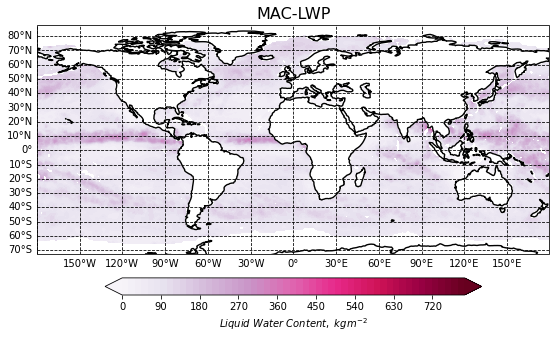

In [20]:
# Plotting LWP in 'MAC-LWP' dataset:

import cartopy.crs as ccrs   #..projection method
import cartopy.feature as cfeat
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from copy import deepcopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# begin plotting
R = 1
X, Y  = np.meshgrid(lon2, lat)

proj  = ccrs.PlateCarree()
fig101 = plt.figure( figsize=(18*1.5, 5.5 *2.5 *2.))
gs = GridSpec(5, 1, height_ratios=[3, 3, 3, 3, 1])

ax101 = plt.subplot(gs[0], projection= proj)

#..map attributes country border, coastline, Rivers, Lakes..
ax101.add_feature(cfeat.COASTLINE.with_scale('110m'), zorder=1, linewidth = 1.4)
clevel = np.arange(0., 800., 15.)

contourf1 = ax101.contourf(X, Y, dataOUT2[R,:,:], cmap = cm.PuRd, levels = clevel, extend='both')  # predict_label_LWP_PI[t_PI,:,:]
cb1 = fig101.colorbar(contourf1, ax = ax101, orientation='horizontal', label=r"$ Liquid\ Water\ Content,\ g m^{-2}$", shrink=0.25, pad = 0.08)
ax101.set_title("MAC-LWP", fontsize = 16)
extent = [-180, 180, -90, 90]
gl = ax101.gridlines(crs = proj, draw_labels=True, linewidth = 0.8, color = 'k', alpha = 1.0, linestyle = '--', zorder = 99)

gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator(np.arange(extent[0], extent[1], 30.))
gl.ylocator = mticker.FixedLocator(np.arange(extent[2], extent[3], 10.))


plt.show()
# plt.savefig('Regimes_cesm2.png')

## read_var_obs_CERES

In [8]:
path1 = '/glade/scratch/chuyan/obs_data/'
import netCDF4 as nc
import glob as glob
import numpy as np

In [9]:
# --------
folder = path1

fn = glob.glob(folder+"CERES_EBAF-TOA_Ed4.1_Subset_200207-202203.nc")

# print(fn)
print(nc.Dataset(fn[0], 'r').variables)
data = nc.Dataset(fn[0], 'r').variables['toa_sw_all_mon']
Fill_value = nc.Dataset(fn[0], 'r').variables['toa_sw_all_mon']._FillValue
ind_filled = data == Fill_value
print(Fill_value)
# print(ind_filled)
print(np.asarray(data[:]).shape)
print(np.asarray(np.nonzero(ind_filled == True)).shape)
print(np.asarray(nc.Dataset(fn[0], 'r').variables['time'][:]))

{'lon': <class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    long_name: Longitude
    standard_name: longitude
    units: degrees_east
    valid_range: [-180.  360.]
unlimited dimensions: 
current shape = (360,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lat': <class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    long_name: Latitude
    standard_name: latitude
    units: degrees_north
    valid_range: [-90.  90.]
unlimited dimensions: 
current shape = (45,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time': <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    long_name: Time
    units: days since 2000-03-01 00:00:00
    delta_t: 0000-00-01 00:00:00
unlimited dimensions: 
current shape = (237,)
filling on, default _FillValue of -2147483647 used, 'toa_sw_all_mon': <class 'netCDF4._netCDF4.Variable'>
float32 toa_sw_all_mon(time, lat, lon)
    long_name: Top of The Atmosphere Shortwave Flux, All-Sky conditions, Monthly Means
    standard_na

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  # Remove the CWD from sys.path while we load stuff.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  # Remove the CWD from sys.path while we load stuff.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  del sys.path[0]
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  del sys.path[0]


In [42]:
# create a shape = (n, 3) array to store the (year, month, day) cf.datetime object
time_i = np.zeros((len(time_slice), 3))
for i in range(len(time_slice)):

    tt1 = nc.num2date(time_slice[i], f.variables['time'].units,calendar = u'360_day')  # cf.Datetime object: including yr, mon, day, hour, minute, second info
    # print(tt1)
    time_i[i, :] = [tt1.year, tt1.month, tt1.day]
# print(time_i)


NameError: name 'time_slice' is not defined

In [49]:
rsut, lat_ceres, lon_ceres, time_ceres = read_var_obs_CERES(varnm = 'toa_sw_all_mon', valid_range1=[2002, 7, 15], valid_range2=[2016, 12, 31])
rsdt, lat_ceres2, lon_ceres2, time_ceres2 = read_var_obs_CERES(varnm = 'solar_mon', valid_range1=[2002, 7, 15], valid_range2=[2016, 12, 31])
rsutcs, lat_ceres3, lon_ceres3, time_ceres3 = read_var_obs_CERES(varnm = 'toa_sw_clr_c_mon', valid_range1=[2002, 7, 15], valid_range2=[2016, 12, 31])

Fill Value:  -999.0
(174, 45, 360)
Fill Value:  -999.0
(174, 45, 360)
Fill Value:  -999.0
(174, 45, 360)


In [56]:
print(rsut[0, :, 179])
print(rsdt[0, :, 179])
print(rsutcs[0, :, 179])

albedo = rsut / rsdt
albedo_cs = rsutcs / rsdt
print(albedo[1,:,179])
print(albedo_cs[1, :, 179])

print(time_ceres, time_ceres2, time_ceres3)

[4.500e-02 4.300e-02 4.100e-02 4.000e-02 4.100e-02 4.300e-02 4.600e-02
 5.200e-02 6.100e-02 7.600e-02 1.030e-01 1.570e-01 2.590e-01 4.228e-01
 5.402e-01 6.444e-01 7.220e-01 3.382e+00 4.818e+00 8.321e+00 1.044e+01
 1.199e+01 1.473e+01 1.702e+01 1.781e+01 1.968e+01 2.222e+01 2.434e+01
 2.619e+01 2.898e+01 3.006e+01 3.177e+01 3.381e+01 3.709e+01 3.894e+01
 4.063e+01 4.197e+01 4.292e+01 4.406e+01 4.491e+01 4.485e+01 4.650e+01
 4.961e+01 5.581e+01 5.844e+01]
[     nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan   0.1815   0.762
   1.868    3.661    6.357    9.866   13.9     18.35    23.12    28.16
  33.44    38.91    44.55    50.35    56.28    62.32    68.46    74.69
  81.      87.37    93.81   100.3    106.8    113.4    120.     126.6
 133.2    139.9    146.5    153.2    159.9   ]
[1.000e-03 1.000e-03 1.000e-03 1.000e-03 1.000e-03 1.000e-03 1.000e-03
 1.000e-03 1.000e-03 1.000e-03 2.000e-03 2.000e-03 4.000e-03 3.108e

In [11]:
print(lat_ceres)

[-84.5 -83.5 -82.5 -81.5 -80.5 -79.5 -78.5 -77.5 -76.5 -75.5 -74.5 -73.5
 -72.5 -71.5 -70.5 -69.5 -68.5 -67.5 -66.5 -65.5 -64.5 -63.5 -62.5 -61.5
 -60.5 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 -51.5 -50.5 -49.5
 -48.5 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5 -41.5 -40.5]


## pdf of '$\alpha _{cs}$' vs 'MAC-LWP shows as Land/Sea-Ice' 

In [ ]:
# Data processing
# --Liquid water path, Unit in kg m^-2
LWP = inputVar_obs['lwp'] / 1000.
# 1-Sigma Liquid water path statistic error, Unit in Kg m^-2
LWP_error = inputVar_obs['lwp_error'] / 1000.
# the MaskedArray of 'MAC-LWP' dataset
Maskarray_mac = inputVar_obs['maskarray_mac']
# ---

# GMT: Global mean surface air Temperature (2-meter), Unit in K
gmt = inputVar_obs['tas'] * 1.
# SST: Sea Surface Temperature or skin- Temperature, Unit in K
SST = inputVar_obs['sfc_T'] * 1.
# Precip: Precipitation, Unit in mm day^-1 (convert from kg m^-2 s^-1)
Precip = inputVar_obs['P'] * (24. * 60 * 60)
# Eva: Evaporation, Unit in mm day^-1 (here use the latent heat flux from the sfc, unit convert from W m^-2 --> kg m^-2 s^-1 --> mm day^-1)
lh_vaporization = (2.501 - (2.361 * 10**-3) * (SST - 273.15)) * 1e6  # the latent heat of vaporization at the surface Temperature
Eva = inputVar_obs['E'] / lh_vaporization * (24. * 60 * 60)

# MC: Moisture Convergence, represent the water vapor abundance, Unit in mm day^-1
MC = Precip - Eva
print(MC)

# LTS: Lower Tropospheric Stability, Unit in K (the same as Potential Temperature):
k = 0.286

theta_700 = inputVar_obs['T_700'] * (100000. / 70000.)**k
theta_skin = inputVar_obs['sfc_T'] * (100000. / inputVar_obs['sfc_P'])**k
LTS_m = theta_700 - theta_skin  # LTS with np.nan

#.. mask the place with np.nan value
LTS_e = np.ma.masked_where(theta_700==np.nan, LTS_m)
# print(LTS_e)

Subsidence = inputVar_obs['sub']

# SW radiative flux:
Rsdt = inputVar_obs['rsdt']
Rsut = inputVar_obs['rsut']
Rsutcs = inputVar_obs['rsutcs']

albedo = Rsut / Rsdt
albedo_cs = Rsutcs / Rsdt
Alpha_cre = albedo - albedo_cs

# abnormal values:
# albedo_cs[(albedo_cs <= 0.04) & (albedo_cs >= 1.00)] == np.nan
# Alpha_cre[(albedo_cs <= 0.04) & (albedo_cs >= 1.00)] == np.nan
# define Dictionary to store: CCFs(4), gmt, other variables :

dict0_var = {'gmt': gmt, 'SST': SST, 'p_e': MC, 'LTS': LTS_e, 'SUB': Subsidence, 'LWP': LWP, 'rsdt': Rsdt, 'rsut': Rsut, 'rsutcs': Rsutcs, 'albedo' : albedo, 'albedo_cs': albedo_cs, 'alpha_cre': Alpha_cre, 'LWP_statistic_error': LWP_error, 'Maskarray_mac': Maskarray_mac}

# Crop the regions
# crop the variables to the Southern Ocean latitude range: (40 ~ 85^o S)

variable_nas = ['SST', 'p_e', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']

dict1_SO, lat_merra2_so, lon_merra2_so = region_cropping(dict0_var, ['SST', 'p_e', 'LTS', 'SUB'], inputVar_obs['lat_merra2'], inputVar_obs['lon_merra2'], lat_range = [-85., -40.], lon_range = [-180., 180.])
    
dict1_SO, lat_mac_so, lon_mac_so = region_cropping(dict1_SO, ['LWP', 'LWP_statistic_error', 'Maskarray_mac'], inputVar_obs['lat_mac'], inputVar_obs['lon_mac'], lat_range =[-85., -40.], lon_range = [-180., 180.])


mask_int = np.zeros((dict1_SO['LWP'].shape))
print(mask_int.shape)

mask_int[dict1_SO['Maskarray_mac'] == True] = 1.

Count_True_binned, binned_edges, binnumber = stats.binned_statistic(dict1_SO['albedo_cs'].flatten(), mask_int.flatten(), statistic = 'sum', bins = np.arange(0.0, 1, 0.02))
Count_Sum_binned = stats.binned_statistic(dict1_SO['albedo_cs'].flatten(), mask_int.flatten(), statistic = 'count', bins = np.arange(0.0, 1, 0.02))[0]
probability = Count_True_binned / Count_Sum_binned
print(probablity)
# F_landseaIce = Count_binned / np.asarray(np.nonzero(mask_int == 1.)).shape[1]
print(np.sum(F_landdseaIce))



In [59]:
path6 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/plot_file/plots_Sep8_Observation_data/'
plt.figure( figsize = (10, 7.) )
parameters = {'axes.labelsize': 18, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 
         'axes.titlesize': 21, 'legend.fontsize': 20}
plt.rcParams.update(parameters)


x = np.arange(0.00, 0.98, 0.02)
y = probability

plt.plot(x, y, linestyle = '--', c = 'b', linewidth = 2.)
plt.xlabel(r"$ Clear-Sky\ \alpha \ $")
plt.ylabel("Probability ")

plt.title(" where the 'MAC-lwp' dataset has no data")
plt.savefig(path6+'Probability_with_nodata_in_MAC-LWP.jpg')
plt.show()

NameError: name 'probability' is not defined

<Figure size 720x504 with 0 Axes>

# calc_LRMobs_metric

In [ ]:
test_flag = 'test1'

# get the variable:
inputVar_obs = get_OBSLRM(test = test_flag)
# ------------------------ 
# radiation code

# ------------------------

# Data processing
# --Liquid water path, Unit in kg m^-2
LWP = inputVar_obs['lwp'] / 1000.
# 1-Sigma Liquid water path statistic error, Unit in Kg m^-2
LWP_error = inputVar_obs['lwp_error'] / 1000.
# the MaskedArray of 'MAC-LWP' dataset
Maskarray_mac = inputVar_obs['maskarray_mac']
# ---

# GMT: Global mean surface air Temperature (2-meter), Unit in K
gmt = inputVar_obs['tas'] * 1.
# SST: Sea Surface Temperature or skin- Temperature, Unit in K
SST = inputVar_obs['sfc_T'] * 1.
# Precip: Precipitation, Unit in mm day^-1 (convert from kg m^-2 s^-1)
Precip = inputVar_obs['P'] * (24. * 60 * 60)
# Eva: Evaporation, Unit in mm day^-1 (here use the latent heat flux from the sfc, unit convert from W m^-2 --> kg m^-2 s^-1 --> mm day^-1)
lh_vaporization = (2.501 - (2.361 * 10**-3) * (SST - 273.15)) * 1e6  # the latent heat of vaporization at the surface Temperature
Eva = inputVar_obs['E'] / lh_vaporization * (24. * 60 * 60)

# MC: Moisture Convergence, represent the water vapor abundance, Unit in mm day^-1
MC = Precip - Eva
print(MC)

# LTS: Lower Tropospheric Stability, Unit in K (the same as Potential Temperature):
k = 0.286

theta_700 = inputVar_obs['T_700'] * (100000. / 70000.)**k
theta_skin = inputVar_obs['sfc_T'] * (100000. / inputVar_obs['sfc_P'])**k
LTS_m = theta_700 - theta_skin  # LTS with np.nan

#.. mask the place with np.nan value
LTS_e = np.ma.masked_where(theta_700==np.nan, LTS_m)
# print(LTS_e)

Subsidence = inputVar_obs['sub']

# SW radiative flux:
Rsdt = inputVar_obs['rsdt']
Rsut = inputVar_obs['rsut']
Rsutcs = inputVar_obs['rsutcs']

albedo = Rsut / Rsdt
albedo_cs = Rsutcs / Rsdt
Alpha_cre = albedo - albedo_cs
# abnormal values:
albedo_cs[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
Alpha_cre[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan

# define Dictionary to store: CCFs(4), gmt, other variables :
dict0_var = {'gmt': gmt, 'SST': SST, 'p_e': MC, 'LTS': LTS_e, 'SUB': Subsidence, 'LWP': LWP, 'rsdt': Rsdt, 'rsut': Rsut, 'rsutcs': Rsutcs, 'albedo' : albedo, 'albedo_cs': albedo_cs, 'alpha_cre': Alpha_cre, 'LWP_statistic_error': LWP_error, 'Maskarray_mac': Maskarray_mac}

# Crop the regions
# crop the variables to the Southern Ocean latitude range: (40 ~ 85^o S)

variable_nas = ['gmt', 'SST', 'p_e', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre', 'Maskarray_mac']

dict1_SO, lat_merra2_so, lon_merra2_so = region_cropping(dict0_var, ['SST', 'p_e', 'LTS', 'SUB'], inputVar_obs['lat_merra2'], inputVar_obs['lon_merra2'], lat_range = [-85., -40.], lon_range = [-180., 180.])

dict1_SO, lat_mac_so, lon_mac_so = region_cropping(dict1_SO, ['LWP', 'LWP_statistic_error', 'Maskarray_mac'], inputVar_obs['lat_mac'], inputVar_obs['lon_mac'], lat_range =[-85., -40.], lon_range = [-180., 180.])


# Time-scale average
# monthly mean (not changed)
dict2_SO_mon = deepcopy(dict1_SO)

# annually mean variable
dict2_SO_yr = get_annually_dict(dict1_SO, ['gmt', 'SST', 'p_e', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre'], inputVar_obs['times_merra2'], label = 'mon')

# binned (spatial) avergae.
# Southern Ocean 5 * 5 degree bin box

#..set are-mean range and define function
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
x_range = arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) +2.5  #..southern-ocaen latitude edge: 9
# binned Monthly variables:
dict3_SO_mon_bin = {}

for c in range(len(variable_nas)):

    dict3_SO_mon_bin[variable_nas[c]] = binned_cySouthOcean5(dict2_SO_mon[variable_nas[c]], lat_merra2_so, lon_merra2_so)

dict3_SO_mon_bin['gmt'] = binned_cyGlobal5(dict2_SO_mon['gmt'], inputVar_obs['lat_merra2'], lon_merra2_so)
print("End monthly data binned.")

# binned Annually data:
dict3_SO_yr_bin = get_annually_dict(dict3_SO_mon_bin, ['gmt', 'SST', 'p_e', 'LTS', 'SUB'], inputVar_obs['times_merra2'])
print("End annually data binned.")




PLotting:

In [25]:
def stats_metrics_Visualization(modn = 'OBS'):
    
    WD = '/glade/scratch/chuyan/obs_output/'
    path6 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/plot_file/plots_Sep8_Observation_data/'
    folder =  glob.glob(WD + modn + '__' + 'STAT_pi+abr_'+'22x_31y_Sep11th'+ '.npz')
    print(folder)
    
    output_ARRAY = np.load(folder[0], allow_pickle=True)  # str(TR_sst)
    x_gcm = np.asarray(output_ARRAY['bound_x'])
    y_gcm = np.asarray(output_ARRAY['bound_y'])
    output_stat1 = output_ARRAY['stats_1']
    output_stat2 = output_ARRAY['stats_4']

    fig3, ax3  = plt.subplots(1, 2, figsize = (15.2, 10.4))  #(16.2, 9.3))

    #..defined a proper LWP ticks within its range
    p10_valuespace1 = np.nanpercentile(output_stat1, 25.) - np.nanpercentile(output_stat1, 15.)
    levels_value1 = np.linspace(np.nanpercentile(output_stat1, 1.5)-p10_valuespace1, np.nanpercentile(output_stat1, 97) + p10_valuespace1, 164)  # arange(0.368, 0.534, 0.002) 
    # print(levels_value1)
    p10_valuespace2 = np.nanpercentile(output_stat2, 25.) - np.nanpercentile(output_stat2, 15.)
    levels_value2 = np.linspace(np.nanpercentile(output_stat2, 1.5)-p10_valuespace2, np.nanpercentile(output_stat2, 99.5) + p10_valuespace2, 164)
    # print(levels_value2)
    
    #..print(linspace(nanpercentile(output_stat, 1.5), nanpercentile(output_stat, 99.5), 164))
    #..pick the desired colormap
    cmap  = plt.get_cmap('YlOrRd') 
    cmap_2 = plt.get_cmap('viridis_r')   # 'YlOrRd'
    norm1 = BoundaryNorm(levels_value1, ncolors= cmap.N, extend='both')
    norm2 = BoundaryNorm(levels_value2, ncolors= cmap_2.N, extend='both')

    im1  = ax3[0].pcolormesh(x_gcm, y_gcm, np.array(output_stat1), cmap=cmap, norm= norm1)   #..anmean_LWP_bin_Tskew_wvp..LWP_bin_Tskin_sub
    ax3[0].set_xlabel('SUB at 500mb, '+ r'$Pa s^{-1}$', fontsize= 15)
    ax3[0].set_ylabel('SST, ' + 'K', fontsize= 15)
    ax3[0].set_title(r"$(a)\ RMSE:(LWP_{predi}|{period1} - LWP_{OBS}|{period1})$", loc='left', fontsize = 11)
    
    im2  = ax3[1].pcolormesh(x_gcm, y_gcm, np.asarray(output_stat2), cmap=cmap_2, norm= norm2)
    ax3[1].set_xlabel('SUB at 500mb, '+ r'$Pa s^{-1}$', fontsize= 15)
    ax3[1].set_ylabel('SST, ' + 'K', fontsize= 15)
    ax3[1].set_title(r"$(b)\ R^{2}(LWP_{predi}|{period2}\ with\ LWP{OBS}|{period2})$", loc='left', fontsize = 11)
    # ax3.set_title("exp 'abrupt-4xCO2' GCM: BCCESM1 predict R_2", loc='left', fontsize = 11)
    
    fig3.colorbar(im1, ax = ax3[0], label= r"$(kg\ m^{-2})$")
    fig3.colorbar(im2, ax = ax3[1], label= r"$ Coefficient of Determination$")

    
    plt.xlabel('SUB at 500mb, '+ r'$Pa s^{-1}$', fontsize= 15)
    plt.ylabel('SST, ' + 'K', fontsize= 15)
    plt.suptitle(modn+ " Bias metrics of predicting LWP", fontsize =18 )

    # plt.legend(loc='upper right',  fontsize= 12)

    # plt.savefig(path6 + "Observational_bias.jpg" )
    return None

['/glade/scratch/chuyan/obs_output/OBS__STAT_pi+abr_22x_31y_Sep11th.npz']


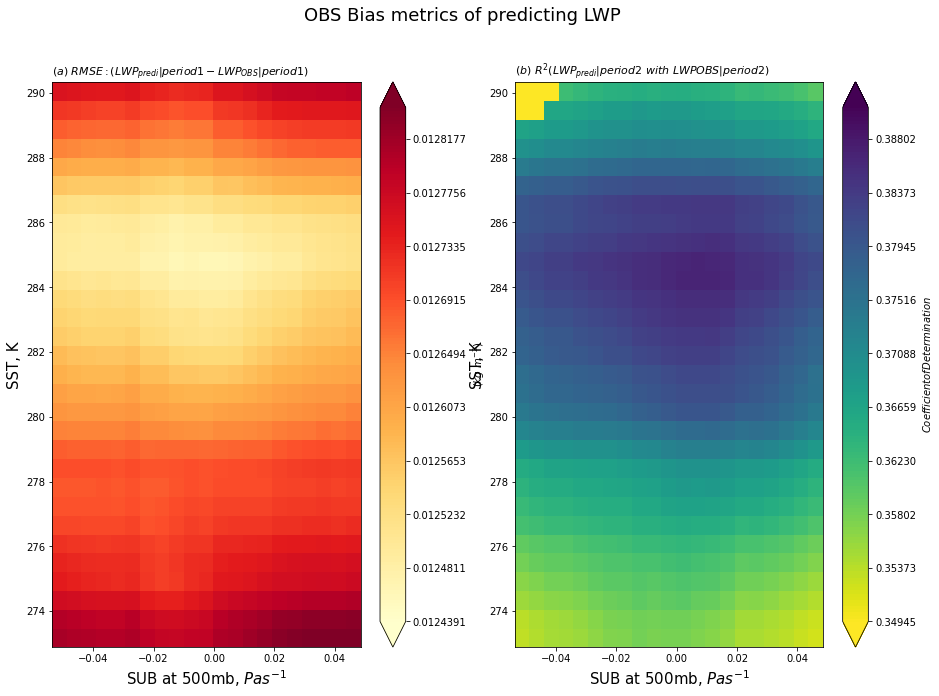

In [26]:
stats_metrics_Visualization()

In [21]:
WD = '/glade/scratch/chuyan/obs_output/'
folder =  glob.glob(WD + 'OBS__' + 'STAT_pi+abr_'+'22x_31y_Sep11th' + '.npz')
print(folder)

output_ARRAY = np.load(folder[0], allow_pickle=True)  # str(TR_sst)

TR_sst1 = output_ARRAY['TR_minabias_SST']
TR_sub1 = output_ARRAY['TR_minabias_SUB']
TR_sst2 = output_ARRAY['TR_maxR2_SST']
TR_sub2 = output_ARRAY['TR_maxR2_SUB']

print("TR_min_abs(bias): " , TR_sst1, '  K ', TR_sub1 , ' Pa/s ')
print("TR_large_pi_R_2: ", TR_sst2, '  K ', TR_sub2 , ' Pa/s ')
# 
# calc_LRM_metrics(float(TR_sst2), float(TR_sub2), **deck[N_of_model])

['/glade/scratch/chuyan/obs_output/OBS__STAT_pi+abr_22x_31y_Sep11th.npz']
TR_min_abs(bias):  284.5258187711201   K  -0.014617270429645265  Pa/s 
TR_large_pi_R_2:  283.9439510076129   K  0.004837945345928386  Pa/s 


# fitLRM_obs_1()

In [10]:
import numpy as np

In [19]:
a = np.ogrid[:3, :4]

print(np.array(a)[1])

[[0 1 2 3]]
